# Calculate enhancer、eRNA、EPI

In [432]:
import pandas as pd
pd.set_option('display.max_columns', None)
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pyBigWig

In [ ]:
# 定义函数，如果eRNA的起始或终止位点在promoter内，则返回True，否则返回False
def ifFilter(row):
    try:
        if (row['eRNA_start'] >= row['promoter_start']) & (row['eRNA_start'] <= row['promoter_end']):
            return True
        elif (row['eRNA_end'] >= row['promoter_start']) & (row['eRNA_end'] <= row['promoter_end']):
            return True
        else:
            return False
    except:
        try:
            if (row['enhancer_start'] >= row['promoter_start']) & (row['enhancer_start'] <= row['promoter_end']):
                return True
            elif (row['enhancer_end'] >= row['promoter_start']) & (row['enhancer_end'] <= row['promoter_end']):
                return True
            else:
                return False
        except:
            raise KeyError

## enhancer identification

In [ ]:
# # sequence data download
# cmd = f"bash download.sh"
# subprocess.run(cmd, shell=True)

In [ ]:
# # Align from original reads
# cmd = f"bash align.sh 10 /home/limh/Reference_Genome/SusScr/BWA/susScr11.fa"
# subprocess.run(cmd, shell=True)

In [430]:
# Histone modification callPeak
files = ['H3K4me1_r2.bam', 'H3K4me1_r1.bam', 'H3K27ac_r2.bam', 'H3K27ac_r1.bam']
for file in files:
    if 'r1' in file:
        inputFile = 'control_H3K4me1_H3K27ac_r1.bam'
    elif 'r2' in file:
        inputFile = 'control_H3K4me1_H3K27ac_r2.bam'
    cmd = f"sicer -t {file} -c {inputFile} -s hg19 -fdr 0.05 -cpu 20 -o ."
    subprocess.run(cmd, shell=True)

Running SICER with given arguments 

Preprocess the H3K4me1_r2.bed file to remove redundancy with threshold of 1 

---------------------------------------------------------------------------------------------------------
chrom    Total plus reads        Retained plus reads       Total minus reads      Retained minus reads   
---------------------------------------------------------------------------------------------------------
chr1          315571                   315571                   315973                   315973          
chr2          289041                   289041                   288561                   288561          
chr3          237529                   237529                   236132                   236132          
chr4          171938                   171938                   171963                   171963          
chr5          198704                   198704                   199052                   199052          
chr6          217404                 

In [433]:
# Get standard-format broadPeak file from sicer result
files = [x for x in os.listdir() if (x.endswith('-W200-G600.scoreisland') and 'H3K' in x)]
for file in files:
    df = pd.read_csv(file, sep='\t', header=None)
    df.insert(3, 'peakName', [f'peak{x}' for x in range(1, df.shape[0]+1)])
    df['strand'] = '.'
    df['signalValue'] = df[3]
    df['pValue'] = df[3]
    df['qValue'] = df[3]
    df.to_csv(file.replace('-W200-G600.scoreisland', '.broadPeak'), sep='\t', header=None, index=False)

In [436]:
# Use idr to combine different replicates
files = [x for x in os.listdir() if (x.endswith('.broadPeak') and 'r1' in x)]
for file in files:
    file_rep2 = file.replace('r1', 'r2')
    outfile = file.replace('r1',  'idr')
    cmd = f'''idr --samples {file} {file_rep2} --input-file-type broadPeak \
        --rank q.value --output-file {outfile} --output-file-type broadPeak \
            --plot --log-output-file {outfile}.log'''
    subprocess.run(cmd, shell=True)

In [437]:
# Filter idr result with threshold as 0.1
files = [x for x in os.listdir() if (x.endswith('.broadPeak') and 'H3K' in x and 'idr.' in x)]
for file in files:
    df = pd.read_csv(file, sep='\t', header=None)
    df = df[df[4]> int(-125 *  np.log2(0.1))]
    df.to_csv(file.replace('.broadPeak', '_filter.broadPeak'), sep='\t', header=None, index=False)

In [465]:
[x for x in os.listdir() if (x.endswith('.broadPeak') and 'H3K' in x and 'idr.' in x)]

['H3K27ac_idr.broadPeak', 'H3K4me1_idr.broadPeak']

In [444]:
# H3K4me1 H3K27ac intersection calculation
H3K4me1_file = [x for x in os.listdir() if (x.endswith('_filter.broadPeak') and 'H3K4me1' in x)][0]
H3K27ac_file = [x for x in os.listdir() if (x.endswith('_filter.broadPeak') and 'H3K27ac' in x)][0]
cmd = f"bedtools intersect -a {H3K27ac_file} -b {H3K4me1_file} > H3K4me1_H3K27ac_intersect.bed"
subprocess.run(cmd, shell=True)

CompletedProcess(args='bedtools intersect -a H3K27ac_idr_filter.broadPeak -b H3K4me1_idr_filter.broadPeak > H3K4me1_H3K27ac_intersect.bed', returncode=0)

**NOTE:** Now the score in file "H3K4me1_H3K27ac_intersect.bed" is the H3K27ac broadPeak score. We can use this score to define the score of enhancer

In [451]:
# Retain H3K4me1 H3K27ac intersection part which show lower H3K4me3 histone modification signal. Get primary enhancer.
H3K4me1_bam = [x for x in os.listdir() if (x.endswith('.bam') and x.startswith('H3K4me1'))]
for file in H3K4me1_bam:
    if f"{file}.bai" in os.listdir():
        continue
    cmd = f"samtools index -@ 20 {file}"
    subprocess.run(cmd, shell=True)
cmd = f'''bamCompare -b1 {H3K4me1_bam[0]} -b2 {H3K4me1_bam[1]} --outFileName H3K4me1_all.bw \
          --normalizeUsing CPM --binSize 10 --operation add --numberOfProcessors 20 --scaleFactorsMethod None'''
subprocess.run(cmd, shell=True)
H3K4me3_bam = [x for x in os.listdir() if (x.endswith('.bam') and x.startswith('H3K4me3'))]
for file in H3K4me3_bam:
    if f"{file}.bai" in os.listdir():
        continue
    cmd = f"samtools index -@ 20 {file}"
    subprocess.run(cmd, shell=True)
cmd = f'''bamCompare -b1 {H3K4me3_bam[0]} -b2 {H3K4me3_bam[1]} --outFileName H3K4me3_all.bw \
            --normalizeUsing CPM --binSize 10 --operation add --numberOfProcessors 20 --scaleFactorsMethod None'''
subprocess.run(cmd, shell=True)

normalization: CPM
normalization: CPM
bamFilesList: ['H3K4me1_r2.bam', 'H3K4me1_r1.bam']
binLength: 10
numberOfSamples: 0
blackListFileName: None
skipZeroOverZero: False
bed_and_bin: False
genomeChunkSize: None
defaultFragmentLength: read length
numberOfProcessors: 20
verbose: False
region: None
bedFile: None
minMappingQuality: None
ignoreDuplicates: False
chrsToSkip: []
stepSize: 10
center_read: False
samFlag_include: None
samFlag_exclude: None
minFragmentLength: 0
maxFragmentLength: 0
zerosToNans: False
smoothLength: None
save_data: False
out_file_for_raw_data: None
maxPairedFragmentLength: 1000
normalization: CPM
normalization: CPM
bamFilesList: ['H3K4me3_r2.bam', 'H3K4me3_r1.bam']
binLength: 10
numberOfSamples: 0
blackListFileName: None
skipZeroOverZero: False
bed_and_bin: False
genomeChunkSize: None
defaultFragmentLength: read length
numberOfProcessors: 20
verbose: False
region: None
bedFile: None
minMappingQuality: None
ignoreDuplicates: False
chrsToSkip: []
stepSize: 10
center_r

CompletedProcess(args='bamCompare -b1 H3K4me3_r2.bam -b2 H3K4me3_r1.bam --outFileName H3K4me3_all.bw             --normalizeUsing CPM --binSize 10 --operation add --numberOfProcessors 20 --scaleFactorsMethod None', returncode=0)

In [452]:
H3K4me1_control_bam = ['control_H3K4me1_H3K27ac_r1.bam', 'control_H3K4me1_H3K27ac_r2.bam']
for file in H3K4me1_control_bam:
    if f"{file}.bai" in os.listdir():
        continue
    cmd = f"samtools index -@ 20 {file}"
    subprocess.run(cmd, shell=True)
cmd = f'''bamCompare -b1 {H3K4me1_control_bam[0]} -b2 {H3K4me1_control_bam[1]} --outFileName H3K4me1_control.bw \
          --normalizeUsing CPM --binSize 10 --operation add --numberOfProcessors 20 --scaleFactorsMethod None'''
subprocess.run(cmd, shell=True)

H3K4me3_control_bam = ['control_H3K4me3_r1.bam', 'control_H3K4me3_r2.bam']
for file in H3K4me3_control_bam:
    if f"{file}.bai" in os.listdir():
        continue
    cmd = f"samtools index -@ 20 {file}"
    subprocess.run(cmd, shell=True)
cmd = f'''bamCompare -b1 {H3K4me3_control_bam[0]} -b2 {H3K4me3_control_bam[1]} --outFileName H3K4me3_control.bw \
          --normalizeUsing CPM --binSize 10 --operation add --numberOfProcessors 20 --scaleFactorsMethod None'''
subprocess.run(cmd, shell=True)

normalization: CPM
normalization: CPM
bamFilesList: ['control_H3K4me1_H3K27ac_r1.bam', 'control_H3K4me1_H3K27ac_r2.bam']
binLength: 10
numberOfSamples: 0
blackListFileName: None
skipZeroOverZero: False
bed_and_bin: False
genomeChunkSize: None
defaultFragmentLength: read length
numberOfProcessors: 20
verbose: False
region: None
bedFile: None
minMappingQuality: None
ignoreDuplicates: False
chrsToSkip: []
stepSize: 10
center_read: False
samFlag_include: None
samFlag_exclude: None
minFragmentLength: 0
maxFragmentLength: 0
zerosToNans: False
smoothLength: None
save_data: False
out_file_for_raw_data: None
maxPairedFragmentLength: 1000
normalization: CPM
normalization: CPM
bamFilesList: ['control_H3K4me3_r1.bam', 'control_H3K4me3_r2.bam']
binLength: 10
numberOfSamples: 0
blackListFileName: None
skipZeroOverZero: False
bed_and_bin: False
genomeChunkSize: None
defaultFragmentLength: read length
numberOfProcessors: 20
verbose: False
region: None
bedFile: None
minMappingQuality: None
ignoreDuplic

CompletedProcess(args='bamCompare -b1 control_H3K4me3_r1.bam -b2 control_H3K4me3_r2.bam --outFileName H3K4me3_control.bw           --normalizeUsing CPM --binSize 10 --operation add --numberOfProcessors 20 --scaleFactorsMethod None', returncode=0)

In [453]:
me1BW = pyBigWig.open('H3K4me1_all.bw')
me3BW = pyBigWig.open('H3K4me3_all.bw')
me1ControlBW = pyBigWig.open('H3K4me1_control.bw')
me3ControlBW = pyBigWig.open('H3K4me3_control.bw')

In [459]:
def ifRetain(row, me1BW, me3BW, me1ControlBW, me3ControlBW):
    chr = row[0]
    start = row[1]
    end = row[2]
    me1Score = np.array(me1BW.stats(chr, start, end, type='sum'))[0]
    me3Score = np.array(me3BW.stats(chr, start, end, type='sum'))[0]
    me1ControlScore = np.array(me1ControlBW.stats(chr, start, end, type='sum'))[0]
    me3ControlScore = np.array(me3ControlBW.stats(chr, start, end, type='sum'))[0]
    me1NetScore = me1Score - me1ControlScore
    me3NetScore = me3Score - me3ControlScore
    if me1NetScore > 1.5 * me3NetScore:
        return True, me1NetScore, me3NetScore
    else:
        return False, me1NetScore, me3NetScore

In [461]:
df = pd.read_csv('H3K4me1_H3K27ac_intersect.bed', sep='\t', header=None)
df['result'] = df.apply(ifRetain, axis=1, args=(me1BW, me3BW, me1ControlBW, me3ControlBW))
df[['retain', 'me1Score', 'me3Score']] = df['result'].apply(pd.Series)

In [462]:
me1BW.close()
me3BW.close()
me1ControlBW.close()
me3ControlBW.close()

In [463]:
df[df['retain']][[0,1,2]].to_csv('enhancer_primary.bed', sep='\t', header=None, index=False)

In [ ]:

# ATAC-seq data process to get broadPeak.
files = [x for x in os.listdir() if ((x.endswith('rmdup.bam')) and ('ATAC' in x))]
for file in files:
    cmd = f"sicer -t {file} -s susScr11 -fdr 0.05 -cpu 20 -o ."
    subprocess.run(cmd, shell=True)
files = [x for x in os.listdir() if (x.endswith('-W200-G600.scoreisland') and 'ATAC' in x)]
for file in files:
    df = pd.read_csv(file, sep='\t', header=None)
    df.insert(3, 'peakName', [f'peak{x}' for x in range(1, df.shape[0]+1)])
    df['strand'] = '.'
    df['signalValue'] = df[3]
    df['pValue'] = df[3]
    df['qValue'] = df[3]
    df.to_csv(file.replace('-W200-G600.scoreisland', '.broadPeak'), sep='\t', header=None, index=False)
    
# Use idr to combine different replicates
files = [x for x in os.listdir() if (x.endswith('.broadPeak') and 'ATAC' in x and 'r1' in x)]
for file in files:
    file_rep2 = file.replace('r1', 'r2')
    outfile = file.replace('r1',  'idr')
    cmd = f'''idr --samples {file} {file_rep2} --input-file-type broadPeak \
        --rank q.value --output-file {outfile} --output-file-type broadPeak \
            --plot --log-output-file {outfile}.log'''
    subprocess.run(cmd, shell=True)
    
# Filter idr result with threshold as 0.1
files = [x for x in os.listdir() if (x.endswith('.broadPeak') and 'ATAC' in x and 'idr' in x)]
for file in files:
    df = pd.read_csv(file, sep='\t', header=None)
    df = df[df[4]> int(-125 *  np.log2(0.1))]
    df.to_csv(file.replace('.broadPeak', '_filter.broadPeak'), sep='\t', header=None, index=False)

# Filter primary enhancer with its DNase broadPeak. Obtain final enhancer.
DNase_file = [x for x in os.listdir() if (x.endswith('_filter.broadPeak') and 'ATAC' in x)][0]
cmd = f"bedtools intersect -a enhancer_primary.bed -b {DNase_file} -u -f 0.5 -F 0.5 -e > enhancer.bed"
subprocess.run(cmd, shell=True)er -t {file} -c {inputFile} -s hg38 -fdr 0.05 -cpu 20 -o ."
    subprocess.run(cmd, shell=True)
# 为得到的broadPeak创建规范的broadPeak文件
files = [x for x in os.listdir() if (x.endswith('-W200-G600.scoreisland') and 'H3K' in x)]
for file in files:
    df = pd.read_csv(file, sep='\t', header=None)
    df.insert(3, 'peakName', [f'peak{x}' for x in range(1, df.shape[0]+1)])
    df['strand'] = '.'
    df['signalValue'] = df[3]
    df['pValue'] = df[3]
    df['qValue'] = df[3]
    df.to_csv(file.replace('-W200-G600.scoreisland', '.broadPeak'), sep='\t', header=None, index=False)
# broadPeak计算idr
files = [x for x in os.listdir() if (x.endswith('.broadPeak') and 'H3K' in x and 'r1' in x)]
for file in files:
    file_rep2 = file.replace('r1', 'r2')
    outfile = file.replace('r1',  'idr')
    cmd = f'''idr --samples {file} {file_rep2} --input-file-type broadPeak \
        --rank q.value --output-file {outfile} --output-file-type broadPeak \
            --plot --log-output-file {outfile}.log'''
    subprocess.run(cmd, shell=True)
# 以阈值0.1过滤idr结果
files = [x for x in os.listdir() if (x.endswith('.broadPeak') and 'H3K' in x and 'idr' in x)]
for file in files:
    df = pd.read_csv(file, sep='\t', header=None)
    df = df[df[4]> int(-125 *  np.log2(0.1))]
    df.to_csv(file.replace('.broadPeak', '_filter.broadPeak'), sep='\t', header=None, index=False)

## eRNA identification

In [ ]:
# Call peak with Homer
referenceGenome = '/home/limh/Reference_Genome/Homo/hg19/genome.fa'
fileList = [x for x in os.listdir() if (x.endswith('_sort_rmdup.bam') and 'PROseq' in x)]
bamFiles = '\t'.join([x for x in fileList])
cmd = f"makeTagDirectory PROseq/ -genome {referenceGenome} -checkGC {bamFiles}"
subprocess.run(cmd, shell=True)
folderList = ['PROseq']
for folder in folderList:
    cmd = f'''findPeaks {folder} -style groseq -o auto -tssSize 250 -minBodySize 250 \
              -tssFold 4 -bodyFold 3 -fragLength 50 -pseudoCount 1 -confPvalue 1.00e-05'''
    subprocess.run(cmd, shell=True)

In [ ]:
# Calculate the eRNA
transcript_df = pd.read_csv('PROseq/transcripts.gtf', sep='\t', header=None, usecols=[0,3,4,5,6,7])
transcript_df[[0,3,4,7,5,6]].to_csv('transcript_hommer_dedup.bed', sep='\t', header=None, index=False)
cmd = f"bedtools intersect -a transcript_hommer_dedup.bed -b enhancer.bed -u -f 0.8 -F 0.8 -e > transcript_enhancer_intersectU.bed"
subprocess.run(cmd, shell=True)
cmd = f"bedtools merge -s -c 4,5,6 -o first,mean,first -d -250 -i transcript_enhancer_intersectU.bed > transcript_enhancer_intersectU_merge.bed"
subprocess.run(cmd, shell=True)

df = pd.read_csv('transcript_enhancer_intersectU_merge.bed', sep='\t', header=None)
df = df[(df[2]-df[1]).between(200, 5000)].drop_duplicates()
df[3] = [f"eRNA{x}" for x in range(1, df.shape[0]+1)]
df.to_csv('eRNA_hommer.bed', sep='\t', header=None, index=False)

## enhancer-promoter interaction / eRNA-promoter interaction construction with HiChIP

In [ ]:
# just use GEO processed HiChIP data, more detail in thesis
df = pd.read_csv('GSM5680734_GM12878.loops.csv')
df[['end1_chr', 'end1_start', 'end1_stop']] = df['source'].str.split('_', expand=True)
df[['end2_chr', 'end2_start', 'end2_stop']] = df['target'].str.split('_', expand=True)
df_filter = df[['end1_chr', 'end1_start', 'end1_stop', 'end2_chr', 'end2_start', 'end2_stop', 'count']]
df_filter.insert(6, 'name', [f"loop{n}" for n in range(df_filter.shape[0])])
df_filter.insert(8, 'end1_strand', '.')
df_filter.insert(9, 'end2_strand', '.')
df_filter = df_filter[df_filter['end1_chr']==df_filter['end2_chr']]
df_filter.to_csv('HiChIP_loop.bedpe', sep='\t', header=None, index=None)

In [3]:
# Calculate interaction between loop anchor and enhancer/promoter
cmd = f"bedtools pairtobed -a HiChIP_loop.bedpe -b enhancer.bg -type either > loop_enhancer.txt"
subprocess.run(cmd, shell=True)
cmd = f"bedtools pairtobed -a HiChIP_loop.bedpe -b eRNA_hommer.bed -type either > loop_eRNA.txt"
subprocess.run(cmd, shell=True)
cmd = f"bedtools pairtobed -a HiChIP_loop.bedpe -b promoter.bed -type either > loop_promoter.txt"
subprocess.run(cmd, shell=True)

CompletedProcess(args='bedtools pairtobed -a HiChIP_loop.bedpe -b promoter.bed -type either > loop_promoter.txt', returncode=0)

In [4]:
# Calculate distal enhance/eRNA promoter interaction
loop_enhancer_df = pd.read_csv("loop_enhancer.txt", sep='\t', header=None, 
                               names=['loop_end1_chr', 'loop_end1_start', 'loop_end1_stop', 'loop_end2_chr', 'loop_end2_start', 'loop_end2_stop',
                                      'loop_name', 'loop_score', 'loop_end1_strand', 'loop_end2_strand',
                                      'enhancer_chr', 'enhancer_start', 'enhancer_stop', 'enhancer_name', 'enhancer_score', 'enhancer_strand'])

loop_eRNA_df = pd.read_csv("loop_eRNA.txt", sep='\t', header=None, 
                               names=['loop_end1_chr', 'loop_end1_start', 'loop_end1_stop', 'loop_end2_chr', 'loop_end2_start', 'loop_end2_stop',
                                      'loop_name', 'loop_score', 'loop_end1_strand', 'loop_end2_strand',
                                      'enhancer_chr', 'enhancer_start', 'enhancer_stop', 'enhancer_name', 'enhancer_score', 'enhancer_strand'])

loop_promoter_df = pd.read_csv("loop_promoter.txt", sep='\t', header=None, 
                               names=['loop_end1_chr', 'loop_end1_start', 'loop_end1_stop', 'loop_end2_chr', 'loop_end2_start', 'loop_end2_stop',
                                      'loop_name', 'loop_score', 'loop_end1_strand', 'loop_end2_strand',
                                      'promoter_chr', 'promoter_start', 'promoter_stop', 'geneName', 'promoter_score', 'promoter_strand'])

epi_loop_df = pd.merge(loop_enhancer_df, loop_promoter_df, on=["loop_end1_chr", 'loop_end1_start', 'loop_end1_stop', 'loop_end2_chr', 'loop_end2_start', 'loop_end2_stop'], how='inner')
eRNApi_loop_df = pd.merge(loop_eRNA_df, loop_promoter_df, on=["loop_end1_chr", 'loop_end1_start', 'loop_end1_stop', 'loop_end2_chr', 'loop_end2_start', 'loop_end2_stop'], how='inner')
epi_distal_df = epi_loop_df[['enhancer_chr', 'enhancer_start', 'enhancer_stop', 'promoter_chr', 'promoter_start', 'promoter_stop', 'enhancer_name', 'geneName', 'enhancer_strand', 'promoter_strand']].drop_duplicates()
eRNApi_distal_df = eRNApi_loop_df[['enhancer_chr', 'enhancer_start', 'enhancer_stop', 'promoter_chr', 'promoter_start', 'promoter_stop', 'enhancer_name', 'geneName', 'enhancer_strand', 'promoter_strand']].drop_duplicates()

In [6]:
# Calculate proximal enhancer promoter interaction
genomeSize = '/home/Reference_Genome/Homo_sapiens/UCSC/hg19/Sequence/WholeGenomeFasta/genome.size.txt'
cmd = f"bedtools makewindows -g {genomeSize} -w 10000 > 10000window.bed"
subprocess.run(cmd, shell=True)
cmd = f"bedtools intersect -a enhancer.bg -b 10000window.bed -f 0.8 -F 0.8 -e -wo > enhancer_10000window_intersectWo.txt"
subprocess.run(cmd, shell=True)
cmd = f"bedtools intersect -a eRNA_hommer.bed -b 10000window.bed -f 0.8 -F 0.8 -e -wo > eRNA_10000window_intersectWo.txt"
subprocess.run(cmd, shell=True)
cmd = f"bedtools intersect -a promoter.bed -b 10000window.bed -f 0.8 -F 0.8 -e -wo > promoter_10000window_intersectWo.txt"
subprocess.run(cmd, shell=True)
enhancer_10000window_intersectWo_df = pd.read_csv('enhancer_10000window_intersectWo.txt', sep='\t', header=None, 
                                                  names=['enhancer_chr', 'enhancer_start', 'enhancer_stop', 'enhancer_name', 'enhancer_score', 'enhancer_strand',
                                                         'window_chr', 'window_start', 'window_stop', 'intersect'])
eRNA_10000window_intersectWo_df = pd.read_csv('eRNA_10000window_intersectWo.txt', sep='\t', header=None, 
                                                  names=['enhancer_chr', 'enhancer_start', 'enhancer_stop', 'enhancer_name', 'enhancer_score', 'enhancer_strand',
                                                         'window_chr', 'window_start', 'window_stop', 'intersect'])
promoter_10000window_intersectWo_df = pd.read_csv('promoter_10000window_intersectWo.txt', sep='\t', header=None, 
                                                  names=['promoter_chr', 'promoter_start', 'promoter_stop', 'geneName', 'promoter_score', 'promoter_strand', 
                                                         'window_chr', 'window_start', 'window_stop', 'intersect'])
enhancer_promoter_proximal_df = pd.merge(enhancer_10000window_intersectWo_df, promoter_10000window_intersectWo_df, on=['window_chr', 'window_start', 'window_stop'], how='inner')
eRNA_promoter_proximal_df = pd.merge(eRNA_10000window_intersectWo_df, promoter_10000window_intersectWo_df, on=['window_chr', 'window_start', 'window_stop'], how='inner')

In [7]:
# merge the distal and proximal enhancer promoter interaction
epi_df = pd.concat([epi_distal_df, enhancer_promoter_proximal_df[['enhancer_chr', 'enhancer_start', 'enhancer_stop', 'promoter_chr', 'promoter_start', 'promoter_stop', 'enhancer_name', 'geneName', 'enhancer_strand', 'promoter_strand']]]).drop_duplicates()
epi_df.index = range(epi_df.shape[0])
eRNApi_df = pd.concat([eRNApi_distal_df, eRNA_promoter_proximal_df[['enhancer_chr', 'enhancer_start', 'enhancer_stop', 'promoter_chr', 'promoter_start', 'promoter_stop', 'enhancer_name', 'geneName', 'enhancer_strand', 'promoter_strand']]]).drop_duplicates()
eRNApi_df.index = range(eRNApi_df.shape[0])

# Get rid of enhancer promoter interaction with sequence overlap
def intersect(row) -> bool:
    if (row['enhancer_start'] > row['promoter_start'] and row['enhancer_start'] < row['promoter_stop']) or ( row['enhancer_stop'] > row['promoter_start'] and row['enhancer_stop'] < row['promoter_stop'] ):
        return 0
    else:
        return 1
epi_filter_df = epi_df.loc[epi_df.apply(intersect, axis=1)==1]
eRNApi_filter_df = eRNApi_df.loc[eRNApi_df.apply(intersect, axis=1)==1]

In [8]:
# output the result
epi_filter_df['epi_name'] = epi_filter_df['enhancer_name'].str.cat(epi_filter_df['geneName'], sep=';')
epi_df = epi_filter_df[['enhancer_chr', 'enhancer_start', 'enhancer_stop', 'promoter_chr', 'promoter_start', 'promoter_stop', 'epi_name', 'enhancer_strand', 'promoter_strand']]
epi_df.insert(7, 'score', 1)
epi_df.to_csv('EPI.bedpe', sep='\t', header=None, index=None)

eRNApi_filter_df['epi_name'] = eRNApi_filter_df['enhancer_name'].str.cat(eRNApi_filter_df['geneName'], sep=';')
epi_df = eRNApi_filter_df[['enhancer_chr', 'enhancer_start', 'enhancer_stop', 'promoter_chr', 'promoter_start', 'promoter_stop', 'epi_name', 'enhancer_strand', 'promoter_strand']]
epi_df.insert(7, 'score', 1)
epi_df.to_csv('eRNAPI.bedpe', sep='\t', header=None, index=None)

/tmp/ipykernel_493521/2859205169.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  epi_filter_df['epi_name'] = epi_filter_df['enhancer_name'].str.cat(epi_filter_df['geneName'], sep=';')
/tmp/ipykernel_493521/2859205169.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eRNApi_filter_df['epi_name'] = eRNApi_filter_df['enhancer_name'].str.cat(eRNApi_filter_df['geneName'], sep=';')


# EP similarity analysis

In [9]:
import pandas as pd
import subprocess
import os
import numpy as np
import pyBigWig
pd.set_option('display.max_columns', None)
import pickle

## create script

In [17]:
# get enhancer、promoter from EPI
referenceGenome = '/home/limh/Reference_Genome/Homo/hg19/genome.fa'
epi_df = pd.read_csv('EPI.bedpe', sep='\t', header=None)
epi_df[['eRNA_name', 'promoter_name']] = epi_df[6].str.split(';', expand=True)
epi_df[[0, 1, 2, 'eRNA_name', 7, 8]].drop_duplicates('eRNA_name').to_csv('enhancer_inEPI.bed', sep='\t', header=None, index=None)
epi_df[[3, 4, 5, 'promoter_name', 7, 9]].drop_duplicates('promoter_name').to_csv('promoter_inEPI.bed', sep='\t', header=None, index=None)

# Get fasta of eRNAinEPI,promoterInEPI
cmd = f"bedtools getfasta -fi {referenceGenome} -fo enhancer_inEPI.fa -name -bed enhancer_inEPI.bed -s"
subprocess.run(cmd, shell=True)
cmd = f"bedtools getfasta -fi {referenceGenome} -fo promoter_inEPI.fa -name -bed promoter_inEPI.bed -s"
subprocess.run(cmd, shell=True)

# Split fasta
os.makedirs('EPI_fasta', exist_ok=True)
with open('enhancer_inEPI.fa', 'r') as f:
	for line in f:
		if line.startswith('>'):
			name = line.strip().split('::')[0][1:]
			out = open(f"EPI_fasta/{name}.fa", 'w')
			# out.write(f">{name}\n")
			# out.write(line)
			print('>' + line.strip().split('::')[1], file=out)
		else:
			out.write(line)
	out.close()
with open('promoter_inEPI.fa', 'r') as f:
	for line in f:
		if line.startswith('>'):
			name = line.strip().split('::')[0][1:]
			out = open(f"EPI_fasta/{name}.fa", 'w')
			# out.write(f">{name}\n")
			# out.write(line)
			print('>' + line.strip().split('::')[1], file=out)
		else:
			out.write(line)
	out.close()
    
eRnaPI_df = pd.read_csv('eRNAPI.bedpe', sep='\t', header=None)
eRnaPI_df[['eRNA_name', 'promoter_name']] = eRnaPI_df[6].str.split(';', expand=True)
eRnaPI_df[[0, 1, 2, 'eRNA_name', 7, 8]].drop_duplicates('eRNA_name').to_csv('eRNA_inERnaPI.bed', sep='\t', header=None, index=None)
eRnaPI_df[[3, 4, 5, 'promoter_name', 7, 9]].drop_duplicates('promoter_name').to_csv('promoter_inERnaPI.bed', sep='\t', header=None, index=None)

# Get fasta of eRNAinErnaPI,promoterInErnaPI
cmd = f"bedtools getfasta -fi {referenceGenome} -fo eRNA_inERnaPI.fa -name -bed eRNA_inERnaPI.bed -s"
subprocess.run(cmd, shell=True)
cmd = f"bedtools getfasta -fi {referenceGenome} -fo promoter_inERnaPI.fa -name -bed promoter_inERnaPI.bed -s"
subprocess.run(cmd, shell=True)

# Split fasta
os.makedirs('eRNAPI_fasta', exist_ok=True)
with open('eRNA_inERnaPI.fa', 'r') as f:
	for line in f:
		if line.startswith('>'):
			name = line.strip().split('::')[0][1:]
			out = open(f"eRNAPI_fasta/{name}.fa", 'w')
			# out.write(f">{name}\n")
			# out.write(line)
			print('>' + line.strip().split('::')[1], file=out)
		else:
			out.write(line)
	out.close()
with open('promoter_inERnaPI.fa', 'r') as f:
	for line in f:
		if line.startswith('>'):
			name = line.strip().split('::')[0][1:]
			out = open(f"eRNAPI_fasta/{name}.fa", 'w')
			# out.write(f">{name}\n")
			# out.write(line)
			print('>' + line.strip().split('::')[1], file=out)
		else:
			out.write(line)
	out.close()

In [19]:
# enhancer
# makeblastdb script
genes = [x for x in os.listdir('EPI_fasta') if (x.endswith('.fa') and not x.startswith('enhancer'))]
makedf_bash_file = open('EPI_makedb.sh', 'w')
if os.path.exists('EPI_makedb.log'):
    os.remove('EPI_makedb.log')
for gene in enumerate(genes):
    print(f"makeblastdb -in EPI_fasta/{gene[1]} -dbtype nucl >> EPI_makedb.log", file=makedf_bash_file)
makedf_bash_file.close()

# blast script
epi_list = epi_df[['eRNA_name', 'promoter_name']].values.tolist()
blast_bash_file = open('EPI_blast.sh', 'w')
if os.path.exists('EPI_blastResult.txt'):
    os.remove('EPI_blastResult.txt')
for i in epi_list:
    eRNA = i[0]
    promoter = i[1]
    print(f"blastn -task blastn -query EPI_fasta/{eRNA}.fa -db EPI_fasta/{promoter}.fa -outfmt 6 -evalue 1e-4 >> EPI_blastResult.txt", file=blast_bash_file)
blast_bash_file.close()

In [21]:
# eRNA
# makeblastdb script
genes = [x for x in os.listdir('eRNAPI_fasta') if (x.endswith('.fa') and not x.startswith('eRNA'))]
makedf_bash_file = open('ErnaPI_makedb.sh', 'w')
if os.path.exists('ErnaPI_makedb.log'):
    os.remove('ErnaPI_makedb.log')
for gene in enumerate(genes):
    print(f"makeblastdb -in eRNAPI_fasta/{gene[1]} -dbtype nucl >> ErnaPI_makedb.log", file=makedf_bash_file)
makedf_bash_file.close()

# blast script
eRNApi_list = eRnaPI_df[['eRNA_name', 'promoter_name']].values.tolist()
blast_bash_file = open('ErnaPI_blast.sh', 'w')
# 如果blastResult.txt存在，则删除
if os.path.exists('ErnaPI_blastResult.txt'):
    os.remove('ErnaPI_blastResult.txt')
for i in eRNApi_list:
    eRNA = i[0]
    promoter = i[1]
    print(f"blastn -task blastn -query eRNAPI_fasta/{eRNA}.fa -db eRNAPI_fasta/{promoter}.fa -outfmt 6 -evalue 1e-4 >> ErnaPI_blastResult.txt", file=blast_bash_file)
blast_bash_file.close()

In [ ]:
import subprocess
subprocess.run('bash EPI_makedb.sh', shell=True)
subprocess.run('bash EPI_blast.sh', shell=True)
subprocess.run('bash ErnaPI_makedb.sh', shell=True)
subprocess.run('bash ErnaPI_blast.sh', shell=True)

## enhancer analysis

In [6]:
# Get the sequence similar enhancer in EPI
blastResultFile = 'EPI_blastResult.txt'
blastResultBedFile = 'EPI_enhancerBlastHit.bed'
with open(blastResultFile, 'r') as infile, open(blastResultBedFile, 'w') as outfile:
	for line in infile:
		chromosome = line.split()[0].split(':')[0]
		startPre = int(line.split()[0].split(':')[1].split('-')[0])
		stopPre = int(line.split()[0].split(':')[1].split('-')[1].split('(')[0])
		name = line.split()[0]
		otherName = line.split()[1]
		strand = line.split()[0].split(':')[1].split('(')[1][0]
		if strand == '+' or strand == '.':
			if int(line.split()[6]) < int(line.split()[7]):
				shiftStart = int(line.split()[6])
				shiftEnd = int(line.split()[7])
			elif int(line.split()[6]) > int(line.split()[7]):
				shiftStart = int(line.split()[7])
				shiftEnd = int(line.split()[6])
			start = startPre + shiftStart - 1
			end = startPre + shiftEnd - 1
		elif strand == '-':
			if int(line.split()[6]) < int(line.split()[7]):
				shiftStart = int(line.split()[6])
				shiftEnd = int(line.split()[7])
			elif int(line.split()[6]) > int(line.split()[7]):
				shiftStart = int(line.split()[7])
				shiftEnd = int(line.split()[6])
			end = stopPre - shiftStart
			start = stopPre - shiftEnd
		print(f'{chromosome}\t{start}\t{end}\t{name}\t{otherName}\t{strand}', file=outfile)
        
# Get the sequence similar promoter in EPI
blastResultFile = 'EPI_blastResult.txt'
blastResultBedFile = 'EPI_promoterBlastHit.bed'
with open(blastResultFile, 'r') as infile, open(blastResultBedFile, 'w') as outfile:
	for line in infile:
		chromosome = line.split()[1].split(':')[0]
		startPre = int(line.split()[1].split(':')[1].split('-')[0])
		stopPre = int(line.split()[1].split(':')[1].split('-')[1].split('(')[0])
		name = line.split()[1]
		otherName = line.split()[0]
		strand = line.split()[1].split(':')[1].split('(')[1][0]
		if strand == '+' or strand == '.':
			if int(line.split()[8]) < int(line.split()[9]):
				shiftStart = int(line.split()[8])
				shiftEnd = int(line.split()[9])
			elif int(line.split()[8]) > int(line.split()[9]):
				shiftStart = int(line.split()[9])
				shiftEnd = int(line.split()[8])
			start = startPre + shiftStart - 1
			end = startPre + shiftEnd - 1
		elif strand == '-':
			if int(line.split()[8]) < int(line.split()[9]):
				shiftStart = int(line.split()[8])
				shiftEnd = int(line.split()[9])
			elif int(line.split()[8]) > int(line.split()[9]):
				shiftStart = int(line.split()[9])
				shiftEnd = int(line.split()[8])
			end = stopPre - shiftStart
			start = stopPre - shiftEnd
		print(f'{chromosome}\t{start}\t{end}\t{name}\t{otherName}\t{strand}', file=outfile)


In [8]:
# Get out the TE similar EPI, save as ep_same_{te}.bedpe
promoter_blast_df = pd.read_csv('EPI_promoterBlastHit.bed', sep='\t', header=None)
enhancer_blast_df = pd.read_csv('EPI_enhancerBlastHit.bed', sep='\t', header=None)
promoter_blast_df.columns = ['promoter_blastHit_chr', 'promoter_blastHit_start', 'promoter_blastHit_end', 'promoter', 'eRNA', 'promoter_strand']
enhancer_blast_df.columns = ['eRNA_blastHit_chr', 'eRNA_blastHit_start', 'eRNA_blastHit_end', 'eRNA', 'promoter', 'eRNA_strand']
epi_df = pd.read_csv('EPI.bedpe', sep='\t', header=None)
epi_df.columns = ['eRNA_chr', 'eRNA_start', 'eRNA_end', 'promoter_chr', 'promoter_start', 'promoter_end',
               'epi_name', 'eRNA_score', 'eRNA_strand', 'promoter_strand']
promoter_blast_df['promoter_chr'] = promoter_blast_df['promoter'].str.split(':').str[0]
promoter_blast_df['promoter_start'] = promoter_blast_df['promoter'].str.split(':').str[1].str.split('-').str[0].str.split('(').str[0].astype(int)
promoter_blast_df['promoter_end'] = promoter_blast_df['promoter'].str.split(':').str[1].str.split('-').str[1].str.split('(').str[0].astype(int)
promoter_blast_df['eRNA_chr'] = promoter_blast_df['eRNA'].str.split(':').str[0]
promoter_blast_df['eRNA_start'] = promoter_blast_df['eRNA'].str.split(':').str[1].str.split('-').str[0].str.split('(').str[0].astype(int)
promoter_blast_df['eRNA_end'] = promoter_blast_df['eRNA'].str.split(':').str[1].str.split('-').str[1].str.split('(').str[0].astype(int)

enhancer_blast_df['eRNA_chr'] = enhancer_blast_df['eRNA'].str.split(':').str[0]
enhancer_blast_df['eRNA_start'] = enhancer_blast_df['eRNA'].str.split(':').str[1].str.split('-').str[0].str.split('(').str[0].astype(int)
enhancer_blast_df['eRNA_end'] = enhancer_blast_df['eRNA'].str.split(':').str[1].str.split('-').str[1].str.split('(').str[0].astype(int)
enhancer_blast_df['promoter_chr'] = enhancer_blast_df['promoter'].str.split(':').str[0]
enhancer_blast_df['promoter_start'] = enhancer_blast_df['promoter'].str.split(':').str[1].str.split('-').str[0].str.split('(').str[0].astype(int)
enhancer_blast_df['promoter_end'] = enhancer_blast_df['promoter'].str.split(':').str[1].str.split('-').str[1].str.split('(').str[0].astype(int)

# Get out the intersection between transposon and blastHit
transposonFile = 'hg19.fa.bed'
x = pd.merge(epi_df, promoter_blast_df, on=['eRNA_chr', 'eRNA_start', 'eRNA_end', 'promoter_chr', 
                                            'promoter_start', 'promoter_end', 'promoter_strand'], how='inner')
y = pd.merge(x, enhancer_blast_df, on=['eRNA_chr', 'eRNA_start', 'eRNA_end', 'promoter_chr', 
                                       'promoter_start', 'promoter_end', 'promoter', 'eRNA', 'eRNA_strand'
                                       ], how='inner')
cmd = f"bedtools intersect -a EPI_promoterBlastHit.bed -b {transposonFile} -wo -f 0.8 -F 0.8 -e > EPI_promoterBlastHit_transposon_intersectWo.bed"
subprocess.run(cmd, shell=True)
cmd = f"bedtools intersect -a EPI_enhancerBlastHit.bed -b {transposonFile} -wo -f 0.8 -F 0.8 -e > EPI_enhancerBlastHit_transposon_intersectWo.bed"
subprocess.run(cmd, shell=True)

promoter_blast_te_intersectWo_df = pd.read_csv('EPI_promoterBlastHit_transposon_intersectWo.bed', sep='\t', header=None)
enhancer_blast_te_intersectWo_df = pd.read_csv('EPI_enhancerBlastHit_transposon_intersectWo.bed', sep='\t', header=None)
promoter_blast_te_intersectWo_df = promoter_blast_te_intersectWo_df.rename({
    0:'promoter_blastHit_chr', 1:'promoter_blastHit_start', 2:'promoter_blastHit_end', 
    3:'promoter', 4:'eRNA', 5:'promoter_strand'}, axis=1)
enhancer_blast_te_intersectWo_df = enhancer_blast_te_intersectWo_df.rename({
    0:'eRNA_blastHit_chr', 1:'eRNA_blastHit_start', 2:'eRNA_blastHit_end',
    3:'eRNA', 4:'promoter', 5:'eRNA_strand'}, axis=1)

# merge the promoter and enhancer information together
transposon_similar_EPI_df = pd.merge(
    pd.merge(y, promoter_blast_te_intersectWo_df, on=['promoter_blastHit_chr', 'promoter_blastHit_start', 'promoter_blastHit_end',
                                                  'promoter', 'eRNA', 'promoter_strand'], how='inner'),
    enhancer_blast_te_intersectWo_df, on=['eRNA_blastHit_chr', 'eRNA_blastHit_start', 'eRNA_blastHit_end',
                                            'eRNA', 'promoter', 'eRNA_strand'], how='inner')

transposon_similar_EPI_df = transposon_similar_EPI_df[transposon_similar_EPI_df['12_x'] == transposon_similar_EPI_df['12_y']]
SINE_similar_EPI_df = transposon_similar_EPI_df[transposon_similar_EPI_df['12_x'].str.contains('SINE')]

In [27]:
# seuquence-similar EPI num
print(y['epi_name'].drop_duplicates().shape[0])

# transposon-similar EPI num
print(transposon_similar_EPI_df['epi_name'].drop_duplicates().shape[0])

# SINE-similar EPI num
print(SINE_similar_EPI_df['epi_name'].drop_duplicates().shape[0])

# each transposon ratio in transposon-similar EPI (corrected by copy number)
df = pd.read_csv(transposonFile, sep='\t', header=None)
transposon_num_dict = transposon_similar_EPI_df['12_x'].value_counts()
transposon_copyNum_dict = df[6].value_counts().to_dict()
transposon_num_correct_dict = dict()
for key in transposon_num_dict.keys():
    result = transposon_num_dict[key] / transposon_copyNum_dict[key]
    transposon_num_correct_dict[key] = [result]
for key, value in (pd.DataFrame.from_dict(transposon_num_correct_dict).T / pd.DataFrame.from_dict(transposon_num_correct_dict).T.sum())[0].to_dict().items():
    print(key, round(value, 2))

# result save
for i, j in SINE_similar_EPI_df.groupby('12_x'):
    j[['eRNA_chr', 'eRNA_start', 'eRNA_end', 'promoter_chr', 'promoter_start', 'promoter_end', 'epi_name', 'eRNA_score', 'eRNA_strand', 'promoter_strand']
 ].drop_duplicates('epi_name').to_csv(f"ep_same_{i.replace('/', '_')}.bedpe", sep='\t', header=None, index=None)

7470
7365
SINE/Alu 1.0
Simple_repeat 0.0
SINE/MIR 0.0
LINE/L1 0.0
LINE/L2 0.0
LTR/ERVL-MaLR 0.0
Low_complexity 0.0
Satellite 0.0
DNA/hAT-Charlie 0.0
LTR/ERV1 0.0
Retroposon/SVA 0.0
DNA/TcMar-Tigger 0.0
LTR/ERVL 0.0
LINE/CR1 0.0
DNA/hAT-Tip100 0.0
tRNA 0.0
DNA/TcMar-Tc2 0.0
DNA/hAT-Blackjack 0.0
LTR/ERVK 0.0
DNA/hAT 0.0
LINE/RTE-BovB 0.0
LTR/Gypsy? 0.0
LTR/Gypsy 0.0
DNA/hAT-Tip100? 0.0
LINE/RTE-X 0.0
DNA/hAT? 0.0
SINE/tRNA-Deu 0.0
RC?/Helitron? 0.0
rRNA 0.0


## random Control (50 shuffle)

In [42]:
# random Control (50 shuffle)
import os
epi_df = pd.read_csv('EPI.bedpe', sep='\t', header=None)
epi_df[['eRNA_name', 'promoter_name']] = epi_df[6].str.split(';', expand=True)
epi_df[[0, 1, 2, 'eRNA_name', 7, 8]].drop_duplicates('eRNA_name').to_csv('enhancer_inEPI.bed', sep='\t', header=None, index=None)
epi_df[[3, 4, 5, 'promoter_name', 7, 9]].drop_duplicates('promoter_name').to_csv('promoter_inEPI.bed', sep='\t', header=None, index=None)
for i in range(50):
    epi_list = epi_df[['eRNA_name', 'promoter_name']].values.tolist()
    df = pd.DataFrame(epi_list)
    df[1] = df[1].sample(frac=1, replace=False).reset_index()[1]
    random_epi_list = df.values
    blast_bash_file = open(f'random_EPI_blast_{i}.sh', 'w')
    if os.path.exists(f'random_EPI_blastResult_{i}.txt'):
        os.remove(f'random_EPI_blastResult_{i}.txt')
    for j in random_epi_list:
        eRNA = j[0]
        promoter = j[1]
        print(f"blastn -task blastn -query EPI_fasta/{eRNA}.fa -db EPI_fasta/{promoter}.fa -outfmt 6 -evalue 1e-4 >> random_EPI_blastResult_{i}.txt", file=blast_bash_file)
    blast_bash_file.close()

outfile = open('random_control.sh', 'w')
for i in [x for x in os.listdir() if x.startswith('random_EPI_blast')]:
    print(f"bash {i} &", file=outfile)
print('wait', file=outfile)
outfile.close()

In [ ]:
import subprocess
subprocess.run('bash random_control.sh', shell=True)

In [44]:
from tqdm import tqdm
# random control result analysis
random_seuquence_similar_EPI_num_list = []
random_transposon_similar_EPI_num_list = []
random_SINE_similar_EPI_num_list = []
random_each_transposon_ratio_list = []
transposon_num_df = pd.read_csv(transposonFile, sep='\t', header=None)
transposon_copyNum_dict = transposon_num_df[6].value_counts().to_dict()

for i in tqdm(range(50)):
    random_result_file = f"random_EPI_blastResult_{i}.txt"
    # Get the sequence similar enhancer in EPI
    blastResultFile = f"random_EPI_blastResult_{i}.txt"
    blastResultBedFile = f'random_EPI_enhancerBlastHit_{i}.bed'
    with open(blastResultFile, 'r') as infile, open(blastResultBedFile, 'w') as outfile:
        for line in infile:
            chromosome = line.split()[0].split(':')[0]
            startPre = int(line.split()[0].split(':')[1].split('-')[0])
            stopPre = int(line.split()[0].split(':')[1].split('-')[1].split('(')[0])
            name = line.split()[0]
            otherName = line.split()[1]
            strand = line.split()[0].split(':')[1].split('(')[1][0]
            if strand == '+' or strand == '.':
                if int(line.split()[6]) < int(line.split()[7]):
                    shiftStart = int(line.split()[6])
                    shiftEnd = int(line.split()[7])
                elif int(line.split()[6]) > int(line.split()[7]):
                    shiftStart = int(line.split()[7])
                    shiftEnd = int(line.split()[6])
                start = startPre + shiftStart - 1
                end = startPre + shiftEnd - 1
            elif strand == '-':
                if int(line.split()[6]) < int(line.split()[7]):
                    shiftStart = int(line.split()[6])
                    shiftEnd = int(line.split()[7])
                elif int(line.split()[6]) > int(line.split()[7]):
                    shiftStart = int(line.split()[7])
                    shiftEnd = int(line.split()[6])
                end = stopPre - shiftStart
                start = stopPre - shiftEnd
            print(f'{chromosome}\t{start}\t{end}\t{name}\t{otherName}\t{strand}', file=outfile)
    # Get the sequence similar promoter in EPI
    blastResultFile = f"random_EPI_blastResult_{i}.txt"
    blastResultBedFile = f'random_EPI_promoterBlastHit_{i}.bed'
    with open(blastResultFile, 'r') as infile, open(blastResultBedFile, 'w') as outfile:
        for line in infile:
            chromosome = line.split()[1].split(':')[0]
            startPre = int(line.split()[1].split(':')[1].split('-')[0])
            stopPre = int(line.split()[1].split(':')[1].split('-')[1].split('(')[0])
            name = line.split()[1]
            otherName = line.split()[0]
            strand = line.split()[1].split(':')[1].split('(')[1][0]
            if strand == '+' or strand == '.':
                if int(line.split()[8]) < int(line.split()[9]):
                    shiftStart = int(line.split()[8])
                    shiftEnd = int(line.split()[9])
                elif int(line.split()[8]) > int(line.split()[9]):
                    shiftStart = int(line.split()[9])
                    shiftEnd = int(line.split()[8])
                start = startPre + shiftStart - 1
                end = startPre + shiftEnd - 1
            elif strand == '-':
                if int(line.split()[8]) < int(line.split()[9]):
                    shiftStart = int(line.split()[8])
                    shiftEnd = int(line.split()[9])
                elif int(line.split()[8]) > int(line.split()[9]):
                    shiftStart = int(line.split()[9])
                    shiftEnd = int(line.split()[8])
                end = stopPre - shiftStart
                start = stopPre - shiftEnd
            print(f'{chromosome}\t{start}\t{end}\t{name}\t{otherName}\t{strand}', file=outfile)
    # Get out the TE similar EPI, save as ep_same_{te}.bedpe
    try:
        promoter_blast_df = pd.read_csv(f'random_EPI_promoterBlastHit_{i}.bed', sep='\t', header=None)
        enhancer_blast_df = pd.read_csv(f'random_EPI_enhancerBlastHit_{i}.bed', sep='\t', header=None)
    except:
        random_seuquence_similar_EPI_num_list.append(0)
        random_transposon_similar_EPI_num_list.append(0)
        random_SINE_similar_EPI_num_list.append(0)
        random_each_transposon_ratio_list.append({})
        continue
    promoter_blast_df.columns = ['promoter_blastHit_chr', 'promoter_blastHit_start', 'promoter_blastHit_end', 'promoter', 'eRNA', 'promoter_strand']
    enhancer_blast_df.columns = ['eRNA_blastHit_chr', 'eRNA_blastHit_start', 'eRNA_blastHit_end', 'eRNA', 'promoter', 'eRNA_strand']
    epi_df = pd.read_csv('EPI.bedpe', sep='\t', header=None)
    epi_df.columns = ['eRNA_chr', 'eRNA_start', 'eRNA_end', 'promoter_chr', 'promoter_start', 'promoter_end',
                   'epi_name', 'eRNA_score', 'eRNA_strand', 'promoter_strand']
    promoter_blast_df['promoter_chr'] = promoter_blast_df['promoter'].str.split(':').str[0]
    promoter_blast_df['promoter_start'] = promoter_blast_df['promoter'].str.split(':').str[1].str.split('-').str[0].str.split('(').str[0].astype(int)
    promoter_blast_df['promoter_end'] = promoter_blast_df['promoter'].str.split(':').str[1].str.split('-').str[1].str.split('(').str[0].astype(int)
    promoter_blast_df['eRNA_chr'] = promoter_blast_df['eRNA'].str.split(':').str[0]
    promoter_blast_df['eRNA_start'] = promoter_blast_df['eRNA'].str.split(':').str[1].str.split('-').str[0].str.split('(').str[0].astype(int)
    promoter_blast_df['eRNA_end'] = promoter_blast_df['eRNA'].str.split(':').str[1].str.split('-').str[1].str.split('(').str[0].astype(int)

    enhancer_blast_df['eRNA_chr'] = enhancer_blast_df['eRNA'].str.split(':').str[0]
    enhancer_blast_df['eRNA_start'] = enhancer_blast_df['eRNA'].str.split(':').str[1].str.split('-').str[0].str.split('(').str[0].astype(int)
    enhancer_blast_df['eRNA_end'] = enhancer_blast_df['eRNA'].str.split(':').str[1].str.split('-').str[1].str.split('(').str[0].astype(int)
    enhancer_blast_df['promoter_chr'] = enhancer_blast_df['promoter'].str.split(':').str[0]
    enhancer_blast_df['promoter_start'] = enhancer_blast_df['promoter'].str.split(':').str[1].str.split('-').str[0].str.split('(').str[0].astype(int)
    enhancer_blast_df['promoter_end'] = enhancer_blast_df['promoter'].str.split(':').str[1].str.split('-').str[1].str.split('(').str[0].astype(int)

    # Get out the intersection between transposon and blastHit
    x = pd.merge(epi_df, promoter_blast_df, on=['eRNA_chr', 'eRNA_start', 'eRNA_end', 'promoter_chr', 
                                                'promoter_start', 'promoter_end', 'promoter_strand'], how='inner')
    y = pd.merge(x, enhancer_blast_df, on=['eRNA_chr', 'eRNA_start', 'eRNA_end', 'promoter_chr', 
                                           'promoter_start', 'promoter_end', 'promoter', 'eRNA', 'eRNA_strand'
                                           ], how='inner')
    cmd = f"bedtools intersect -a random_EPI_promoterBlastHit_{i}.bed -b {transposonFile} -wo -f 0.8 -F 0.8 -e > random_EPI_promoterBlastHit_{i}_transposon_intersectWo.bed"
    subprocess.run(cmd, shell=True)
    cmd = f"bedtools intersect -a random_EPI_enhancerBlastHit_{i}.bed -b {transposonFile} -wo -f 0.8 -F 0.8 -e > random_EPI_enhancerBlastHit_{i}_transposon_intersectWo.bed"
    subprocess.run(cmd, shell=True)

    
    promoter_blast_te_intersectWo_df = pd.read_csv(f'random_EPI_promoterBlastHit_{i}_transposon_intersectWo.bed', sep='\t', header=None)
    enhancer_blast_te_intersectWo_df = pd.read_csv(f'random_EPI_enhancerBlastHit_{i}_transposon_intersectWo.bed', sep='\t', header=None)
    promoter_blast_te_intersectWo_df = promoter_blast_te_intersectWo_df.rename({
        0:'promoter_blastHit_chr', 1:'promoter_blastHit_start', 2:'promoter_blastHit_end', 
        3:'promoter', 4:'eRNA', 5:'promoter_strand'}, axis=1)
    enhancer_blast_te_intersectWo_df = enhancer_blast_te_intersectWo_df.rename({
        0:'eRNA_blastHit_chr', 1:'eRNA_blastHit_start', 2:'eRNA_blastHit_end',
        3:'eRNA', 4:'promoter', 5:'eRNA_strand'}, axis=1)

    # merge the promoter and enhancer information together
    transposon_similar_EPI_df = pd.merge(
        pd.merge(y, promoter_blast_te_intersectWo_df, on=['promoter_blastHit_chr', 'promoter_blastHit_start', 'promoter_blastHit_end',
                                                      'promoter', 'eRNA', 'promoter_strand'], how='inner'),
        enhancer_blast_te_intersectWo_df, on=['eRNA_blastHit_chr', 'eRNA_blastHit_start', 'eRNA_blastHit_end',
                                                'eRNA', 'promoter', 'eRNA_strand'], how='inner')

    transposon_similar_EPI_df = transposon_similar_EPI_df[transposon_similar_EPI_df['12_x'] == transposon_similar_EPI_df['12_y']]
    SINE_similar_EPI_df = transposon_similar_EPI_df[transposon_similar_EPI_df['12_x'].str.contains('SINE')]
    
    # seuquence-similar EPI num
    random_seuquence_similar_EPI_num_list.append(y['epi_name'].drop_duplicates().shape[0])

    # transposon-similar EPI num
    random_transposon_similar_EPI_num_list.append(transposon_similar_EPI_df['epi_name'].drop_duplicates().shape[0])

    # SINE-similar EPI num
    random_SINE_similar_EPI_num_list.append(SINE_similar_EPI_df['epi_name'].drop_duplicates().shape[0])

    # each transposon ratio in transposon-similar EPI (corrected by copy number)
    transposon_num_dict = transposon_similar_EPI_df['12_x'].value_counts()
    if len(transposon_num_dict) == 0:
        random_each_transposon_ratio_list.append({})
        continue
    transposon_num_correct_dict = dict()
    transposon_ratio_correct_dict = dict()
    for key in transposon_num_dict.keys():
        result = transposon_num_dict[key] / transposon_copyNum_dict[key]
        transposon_num_correct_dict[key] = [result]
    for key, value in (pd.DataFrame.from_dict(transposon_num_correct_dict).T / pd.DataFrame.from_dict(transposon_num_correct_dict).T.sum())[0].to_dict().items():
        transposon_ratio_correct_dict[key] = round(value, 2)
    random_each_transposon_ratio_list.append(transposon_ratio_correct_dict)
    

100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [27:22<00:00, 32.84s/it]


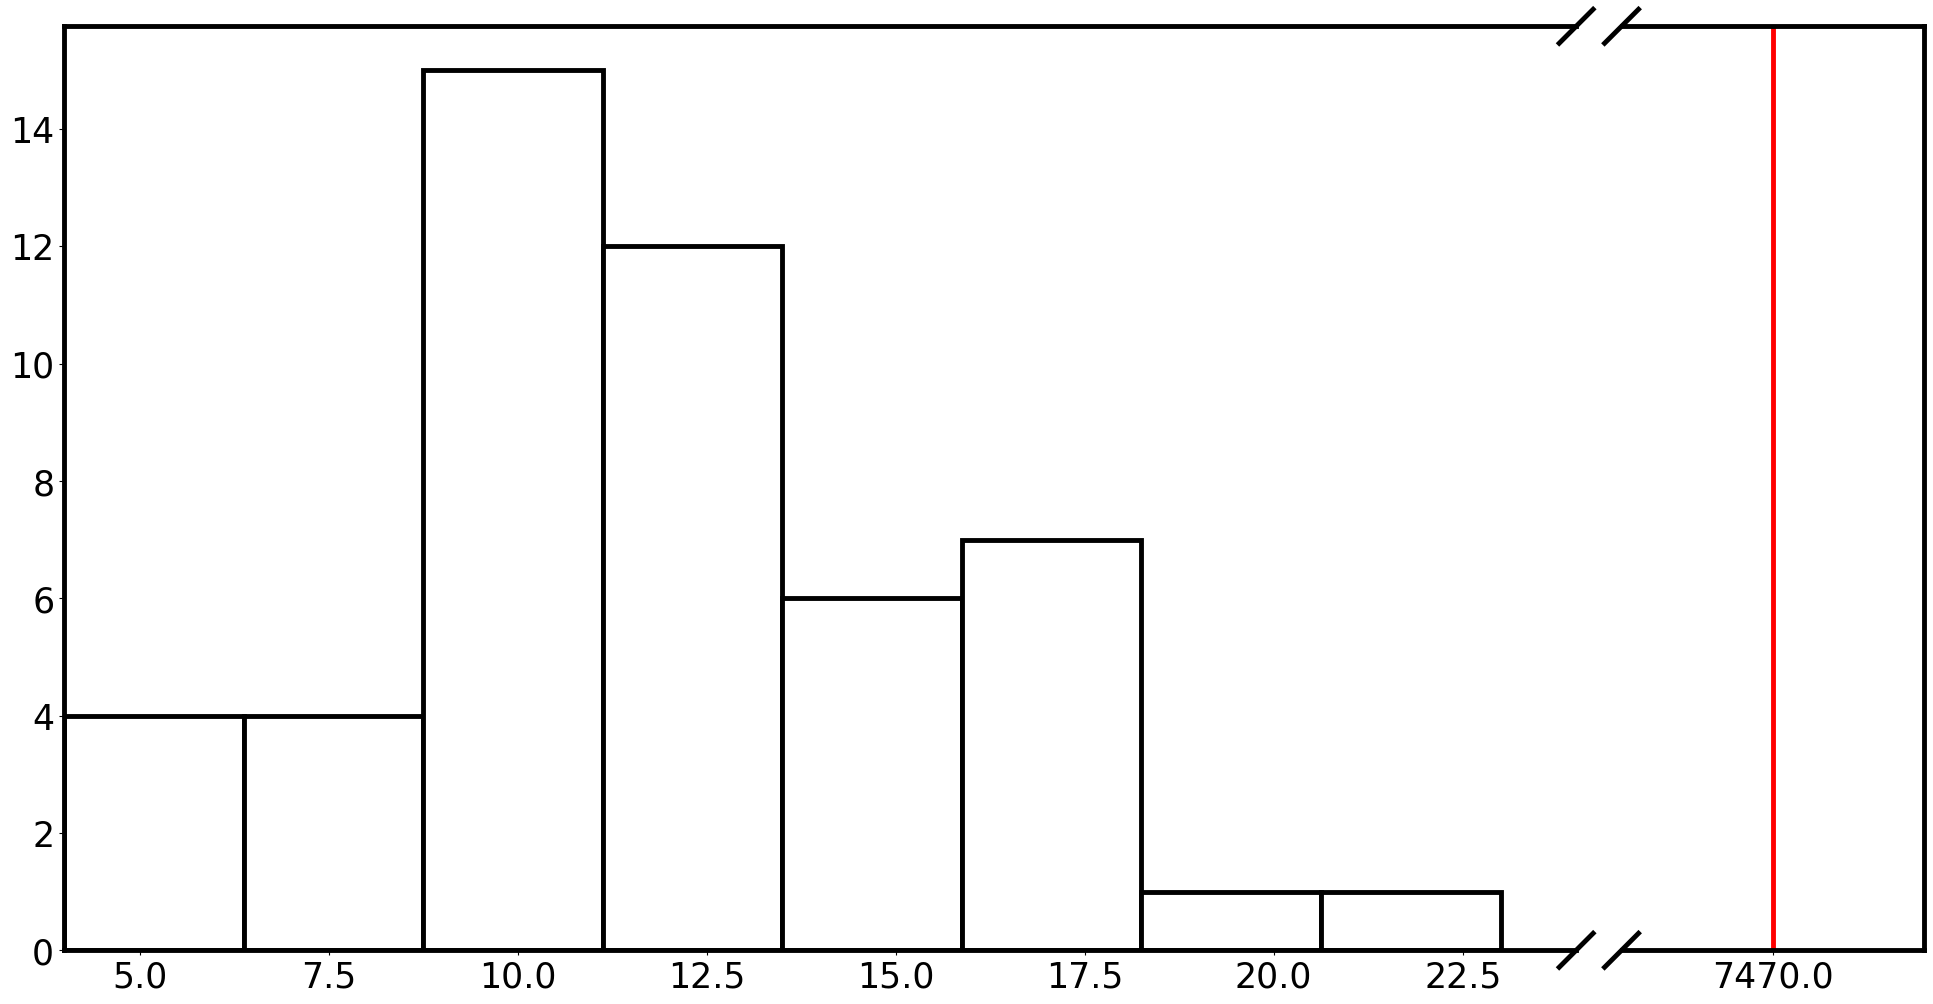

In [53]:
# depict random result picture: transposon similar
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from brokenaxes import brokenaxes

exp_result = 7470
control_min = min(random_transposon_similar_EPI_num_list)
control_max = max(random_transposon_similar_EPI_num_list)

fig = plt.figure(figsize=(24,12), linewidth=10)

ax = brokenaxes(xlims=((control_min, control_max+1), (exp_result-2, exp_result+2)),despine=False, wspace=0.05,d=0.01)

plt.rc('axes', linewidth=3.5)
plt.rcParams['font.size'] = 25  # 14pt font size  


ax.hist(random_transposon_similar_EPI_num_list, bins=8, edgecolor='black', color='white', linewidth=3.5)
ax.axvline(x=exp_result, color='red', linewidth=3.5)

plt.savefig("human_randomControl.svg", format="svg")

## eRNA analysis

In [56]:
# Get the sequence similar enhancer in EPI
blastResultFile = 'ErnaPI_blastResult.txt'
blastResultBedFile = 'ErnaPI_enhancerBlastHit.bed'
with open(blastResultFile, 'r') as infile, open(blastResultBedFile, 'w') as outfile:
	for line in infile:
		chromosome = line.split()[0].split(':')[0]
		startPre = int(line.split()[0].split(':')[1].split('-')[0])
		stopPre = int(line.split()[0].split(':')[1].split('-')[1].split('(')[0])
		name = line.split()[0]
		otherName = line.split()[1]
		strand = line.split()[0].split(':')[1].split('(')[1][0]
		if strand == '+' or strand == '.':
			if int(line.split()[6]) < int(line.split()[7]):
				shiftStart = int(line.split()[6])
				shiftEnd = int(line.split()[7])
			elif int(line.split()[6]) > int(line.split()[7]):
				shiftStart = int(line.split()[7])
				shiftEnd = int(line.split()[6])
			start = startPre + shiftStart - 1
			end = startPre + shiftEnd - 1
		elif strand == '-':
			if int(line.split()[6]) < int(line.split()[7]):
				shiftStart = int(line.split()[6])
				shiftEnd = int(line.split()[7])
			elif int(line.split()[6]) > int(line.split()[7]):
				shiftStart = int(line.split()[7])
				shiftEnd = int(line.split()[6])
			end = stopPre - shiftStart
			start = stopPre - shiftEnd
		print(f'{chromosome}\t{start}\t{end}\t{name}\t{otherName}\t{strand}', file=outfile)
        
# Get the sequence similar promoter in EPI
blastResultFile = 'ErnaPI_blastResult.txt'
blastResultBedFile = 'ErnaPI_promoterBlastHit.bed'
with open(blastResultFile, 'r') as infile, open(blastResultBedFile, 'w') as outfile:
	for line in infile:
		chromosome = line.split()[1].split(':')[0]
		startPre = int(line.split()[1].split(':')[1].split('-')[0])
		stopPre = int(line.split()[1].split(':')[1].split('-')[1].split('(')[0])
		name = line.split()[1]
		otherName = line.split()[0]
		strand = line.split()[1].split(':')[1].split('(')[1][0]
		if strand == '+' or strand == '.':
			if int(line.split()[8]) < int(line.split()[9]):
				shiftStart = int(line.split()[8])
				shiftEnd = int(line.split()[9])
			elif int(line.split()[8]) > int(line.split()[9]):
				shiftStart = int(line.split()[9])
				shiftEnd = int(line.split()[8])
			start = startPre + shiftStart - 1
			end = startPre + shiftEnd - 1
		elif strand == '-':
			if int(line.split()[8]) < int(line.split()[9]):
				shiftStart = int(line.split()[8])
				shiftEnd = int(line.split()[9])
			elif int(line.split()[8]) > int(line.split()[9]):
				shiftStart = int(line.split()[9])
				shiftEnd = int(line.split()[8])
			end = stopPre - shiftStart
			start = stopPre - shiftEnd
		print(f'{chromosome}\t{start}\t{end}\t{name}\t{otherName}\t{strand}', file=outfile)


In [7]:
# Get out the TE similar EPI, save as ep_same_{te}.bedpe
promoter_blast_df = pd.read_csv('ErnaPI_promoterBlastHit.bed', sep='\t', header=None)
enhancer_blast_df = pd.read_csv('ErnaPI_enhancerBlastHit.bed', sep='\t', header=None)
promoter_blast_df.columns = ['promoter_blastHit_chr', 'promoter_blastHit_start', 'promoter_blastHit_end', 'promoter', 'eRNA', 'promoter_strand']
enhancer_blast_df.columns = ['eRNA_blastHit_chr', 'eRNA_blastHit_start', 'eRNA_blastHit_end', 'eRNA', 'promoter', 'eRNA_strand']
epi_df = pd.read_csv('eRNAPI.bedpe', sep='\t', header=None)
epi_df.columns = ['eRNA_chr', 'eRNA_start', 'eRNA_end', 'promoter_chr', 'promoter_start', 'promoter_end',
               'epi_name', 'eRNA_score', 'eRNA_strand', 'promoter_strand']
promoter_blast_df['promoter_chr'] = promoter_blast_df['promoter'].str.split(':').str[0]
promoter_blast_df['promoter_start'] = promoter_blast_df['promoter'].str.split(':').str[1].str.split('-').str[0].str.split('(').str[0].astype(int)
promoter_blast_df['promoter_end'] = promoter_blast_df['promoter'].str.split(':').str[1].str.split('-').str[1].str.split('(').str[0].astype(int)
promoter_blast_df['eRNA_chr'] = promoter_blast_df['eRNA'].str.split(':').str[0]
promoter_blast_df['eRNA_start'] = promoter_blast_df['eRNA'].str.split(':').str[1].str.split('-').str[0].str.split('(').str[0].astype(int)
promoter_blast_df['eRNA_end'] = promoter_blast_df['eRNA'].str.split(':').str[1].str.split('-').str[1].str.split('(').str[0].astype(int)

enhancer_blast_df['eRNA_chr'] = enhancer_blast_df['eRNA'].str.split(':').str[0]
enhancer_blast_df['eRNA_start'] = enhancer_blast_df['eRNA'].str.split(':').str[1].str.split('-').str[0].str.split('(').str[0].astype(int)
enhancer_blast_df['eRNA_end'] = enhancer_blast_df['eRNA'].str.split(':').str[1].str.split('-').str[1].str.split('(').str[0].astype(int)
enhancer_blast_df['promoter_chr'] = enhancer_blast_df['promoter'].str.split(':').str[0]
enhancer_blast_df['promoter_start'] = enhancer_blast_df['promoter'].str.split(':').str[1].str.split('-').str[0].str.split('(').str[0].astype(int)
enhancer_blast_df['promoter_end'] = enhancer_blast_df['promoter'].str.split(':').str[1].str.split('-').str[1].str.split('(').str[0].astype(int)

# Get out the intersection between transposon and blastHit
transposonFile = 'hg19.fa.bed'
x = pd.merge(epi_df, promoter_blast_df, on=['eRNA_chr', 'eRNA_start', 'eRNA_end', 'promoter_chr', 
                                            'promoter_start', 'promoter_end', 'promoter_strand'], how='inner')
y = pd.merge(x, enhancer_blast_df, on=['eRNA_chr', 'eRNA_start', 'eRNA_end', 'promoter_chr', 
                                       'promoter_start', 'promoter_end', 'promoter', 'eRNA', 'eRNA_strand'
                                       ], how='inner')
# cmd = f"bedtools intersect -a ErnaPI_promoterBlastHit.bed -b {transposonFile} -wo -f 0.8 -F 0.8 -e > ErnaPI_promoterBlastHit_transposon_intersectWo.bed"
# subprocess.run(cmd, shell=True)
# cmd = f"bedtools intersect -a ErnaPI_enhancerBlastHit.bed -b {transposonFile} -wo -f 0.8 -F 0.8 -e > ErnaPI_enhancerBlastHit_transposon_intersectWo.bed"
# subprocess.run(cmd, shell=True)

promoter_blast_te_intersectWo_df = pd.read_csv('ErnaPI_promoterBlastHit_transposon_intersectWo.bed', sep='\t', header=None)
enhancer_blast_te_intersectWo_df = pd.read_csv('ErnaPI_enhancerBlastHit_transposon_intersectWo.bed', sep='\t', header=None)
promoter_blast_te_intersectWo_df = promoter_blast_te_intersectWo_df.rename({
    0:'promoter_blastHit_chr', 1:'promoter_blastHit_start', 2:'promoter_blastHit_end', 
    3:'promoter', 4:'eRNA', 5:'promoter_strand'}, axis=1)
enhancer_blast_te_intersectWo_df = enhancer_blast_te_intersectWo_df.rename({
    0:'eRNA_blastHit_chr', 1:'eRNA_blastHit_start', 2:'eRNA_blastHit_end',
    3:'eRNA', 4:'promoter', 5:'eRNA_strand'}, axis=1)

# merge the promoter and enhancer information together
transposon_similar_EPI_df = pd.merge(
    pd.merge(y, promoter_blast_te_intersectWo_df, on=['promoter_blastHit_chr', 'promoter_blastHit_start', 'promoter_blastHit_end',
                                                  'promoter', 'eRNA', 'promoter_strand'], how='inner'),
    enhancer_blast_te_intersectWo_df, on=['eRNA_blastHit_chr', 'eRNA_blastHit_start', 'eRNA_blastHit_end',
                                            'eRNA', 'promoter', 'eRNA_strand'], how='inner')

transposon_similar_EPI_df = transposon_similar_EPI_df[transposon_similar_EPI_df['12_x'] == transposon_similar_EPI_df['12_y']]
SINE_similar_EPI_df = transposon_similar_EPI_df[transposon_similar_EPI_df['12_x'].str.contains('SINE')]

In [58]:
# seuquence-similar EPI num
print(y['epi_name'].drop_duplicates().shape[0])

# transposon-similar EPI num
print(transposon_similar_EPI_df['epi_name'].drop_duplicates().shape[0])

# SINE-similar EPI num
print(SINE_similar_EPI_df['epi_name'].drop_duplicates().shape[0])

# each transposon ratio in transposon-similar EPI (corrected by copy number)
df = pd.read_csv(transposonFile, sep='\t', header=None)
transposon_num_dict = transposon_similar_EPI_df['12_x'].value_counts()
transposon_copyNum_dict = df[6].value_counts().to_dict()
transposon_num_correct_dict = dict()
for key in transposon_num_dict.keys():
    result = transposon_num_dict[key] / transposon_copyNum_dict[key]
    transposon_num_correct_dict[key] = [result]
for key, value in (pd.DataFrame.from_dict(transposon_num_correct_dict).T / pd.DataFrame.from_dict(transposon_num_correct_dict).T.sum())[0].to_dict().items():
    print(key, round(value, 2))

# result save
for i, j in SINE_similar_EPI_df.groupby('12_x'):
    j[['eRNA_chr', 'eRNA_start', 'eRNA_end', 'promoter_chr', 'promoter_start', 'promoter_end', 'epi_name', 'eRNA_score', 'eRNA_strand', 'promoter_strand']
 ].drop_duplicates('epi_name').to_csv(f"eRNAp_same_{i.replace('/', '_')}.bedpe", sep='\t', header=None, index=None)

3111
3061
3049
SINE/Alu 0.99
SINE/MIR 0.0
DNA/hAT-Charlie 0.0
Simple_repeat 0.0
LINE/L1 0.0
LTR/ERVL-MaLR 0.0
LTR/ERV1 0.0
tRNA 0.01
LINE/L2 0.0
LINE/CR1 0.0
LTR/ERVK 0.0


# Calculate the relation between SINE polyA length and corrected ratio

In [126]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pandas as pd
import scipy

In [52]:
a = SINE_similar_EPI_df['9_x'].value_counts()
b = SINE_similar_EPI_df['9_y'].value_counts()

In [138]:
sine_num = pd.DataFrame([a, b]).fillna(0).sum(axis=0)
df = pd.read_csv('hg19.SINE.withpPolyaLength_newMethod2.bed', sep='\t', header=None)
polyA_length = df.groupby(3).agg({14:'mean'})
polyA_length.columns = ['Sine polyA length'] 
polyA_length_std = df.groupby(3).agg({14:'std'})
sine_copy_num = df[3].value_counts()
te_familty_dict = dict(zip(df[3], df[6].str.split('/').str[1]))
polyA_length['sine_copy_num'] = sine_copy_num
polyA_length['sine_num'] = sine_num
polyA_length = polyA_length.fillna(0)
polyA_length['correct_num'] = polyA_length['sine_num']/polyA_length['sine_copy_num']
polyA_length['Correct Ratio'] = polyA_length['correct_num'] / polyA_length['correct_num'].sum()
polyA_length['sine_length_std'] = polyA_length_std
polyA_length['kind'] = polyA_length.index.map(te_familty_dict)

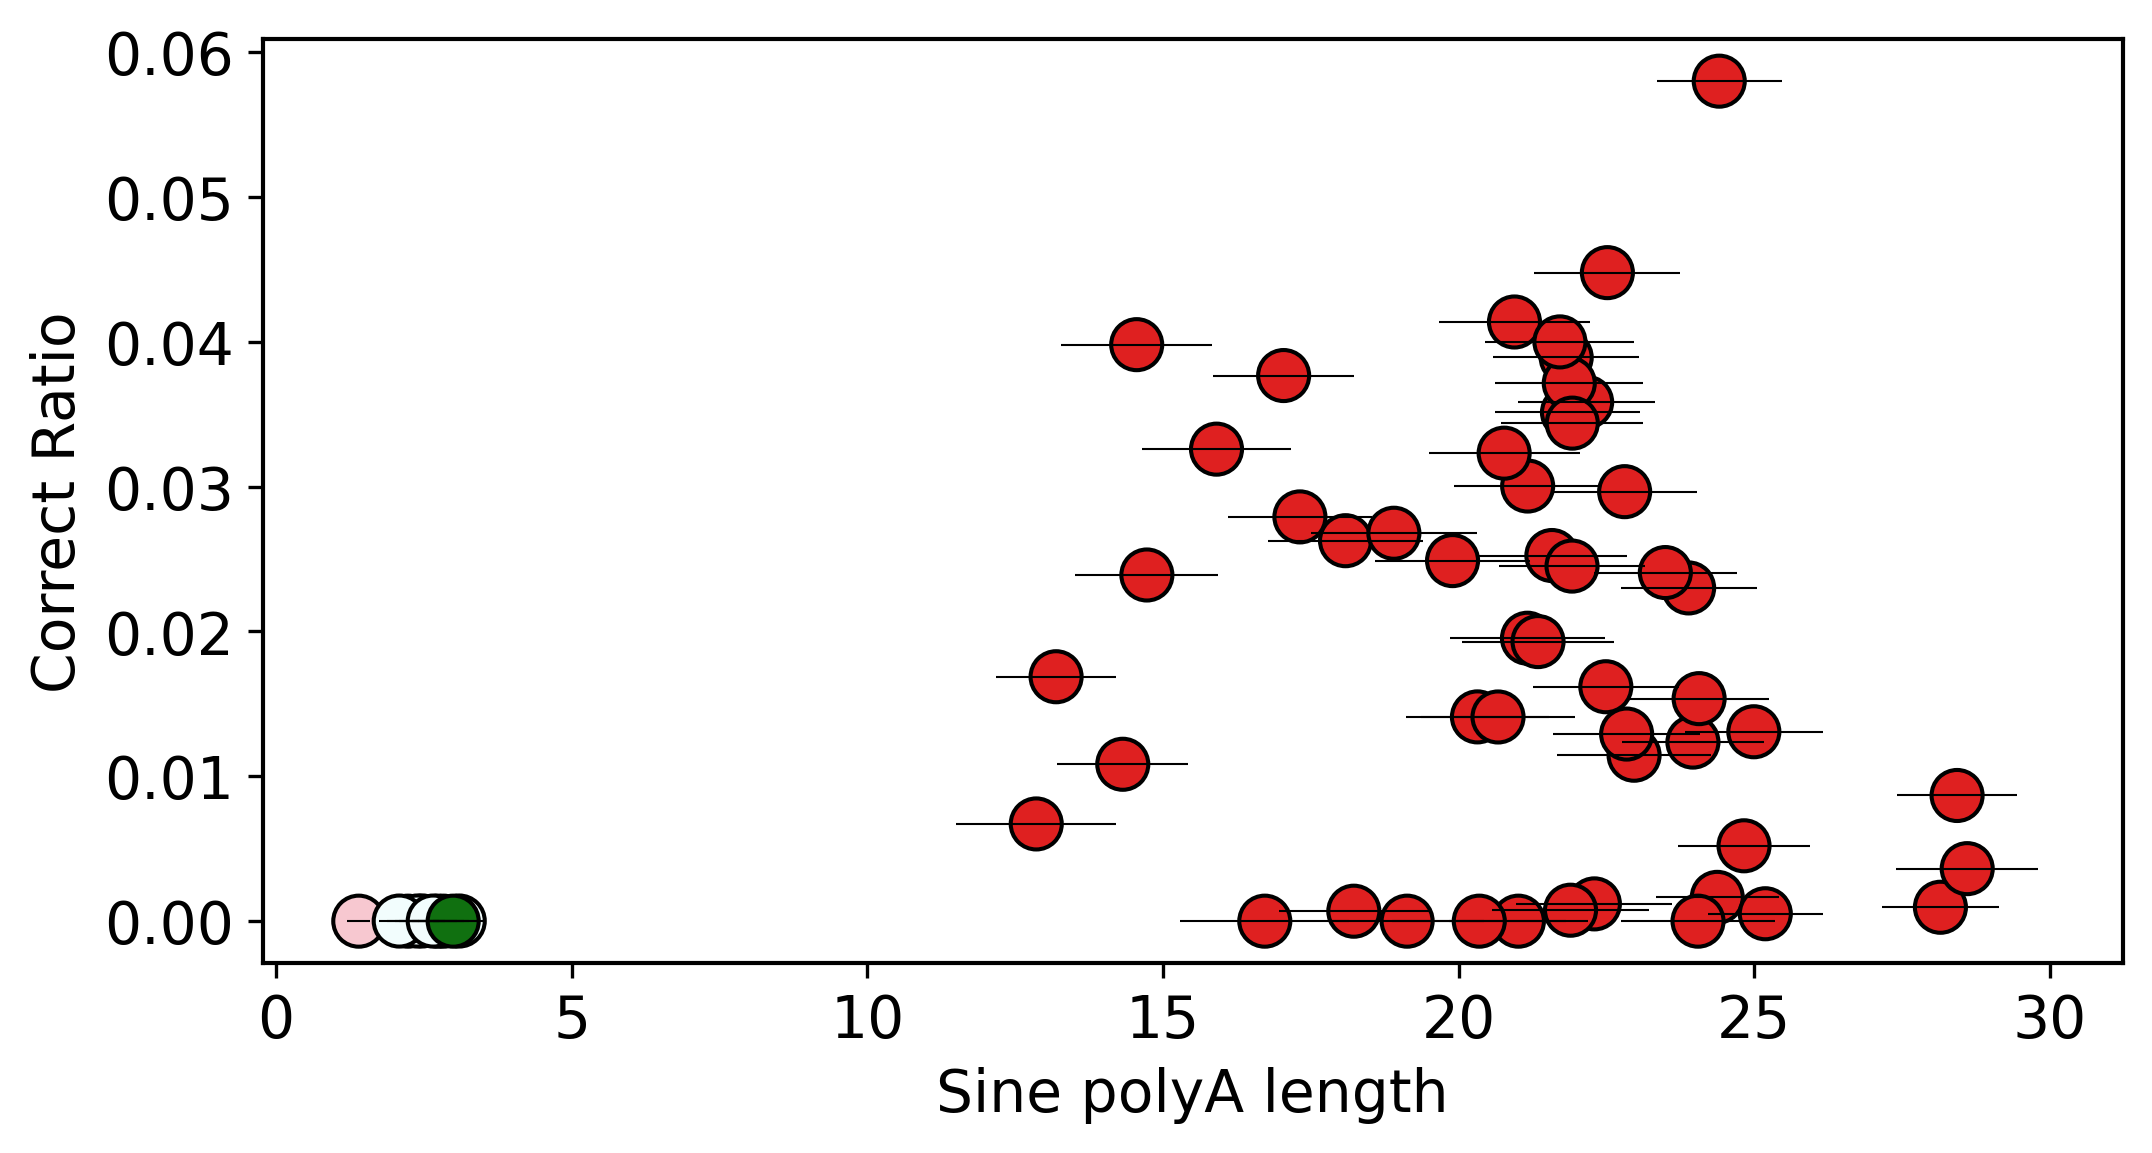

In [144]:
plt.figure(dpi=300,figsize=(8,4))
plt.rc('axes', linewidth=1)
plt.rcParams['font.size'] = 14
ax = sns.scatterplot(data=polyA_length, y='Correct Ratio', x='Sine polyA length', hue='kind', 
                     palette={'Alu':'#df2020', 'MIR':'#f2fdfd', 'tRNA-Deu':'#df9c20', 'tRNA-RTE':'#107010', 'tRNA':'#f7c8d0', '5S-Deu-L2':'#808080'},
                     edgecolor='black',
                     marker='o',
                     s=150,
                     legend=False)
plt.errorbar(x=polyA_length['Sine polyA length'], y=polyA_length['Correct Ratio'], xerr=polyA_length['sine_length_std']*0.1, fmt='none', c='black', 
             elinewidth=0.5, capsize=0)
plt.savefig('CorrectRatio.svg', format='svg', dpi=300)

# Blast Pair Position Analysis
In this section, we want to see the enhancer blast with promoter in polyA region or others. And the distance between the polyA region and the base pair region

In [378]:
import pandas as pd
import subprocess
import numpy as np
pd.set_option('display.max_columns', 200)
import scipy
from scipy import stats

In [238]:
cmd = f"bedtools intersect -a eRNA_hommer.bed -b hg19.Alu.withpPolyaLength_newMethod2.bed -wo -f 0.8 -F 0.8 -e > eRNA_Alu_intersectWo.txt"
subprocess.run(cmd, shell=True)

CompletedProcess(args='bedtools intersect -a eRNA_hommer.bed -b hg19.Alu.withpPolyaLength_newMethod2.bed -wo -f 0.8 -F 0.8 -e > eRNA_Alu_intersectWo.txt', returncode=0)

In [239]:
enhancer_Alu_intersectWo_df = pd.read_csv('eRNA_Alu_intersectWo.txt', sep='\t', header=None)

In [240]:
def getPolyaStart(row):
    if row[11] == '+':
        start = row[8] - row[20]
        stop = row[8]
    else:
        start = row[7]
        stop = row[7] + row[20]
    return start

def getPolyaStop(row):
    if row[11] == '+':
        start = row[8] - row[20]
        stop = row[8]
    else:
        start = row[7]
        stop = row[7] + row[20]
    return stop

enhancer_Alu_intersectWo_df['polyA_start'] = enhancer_Alu_intersectWo_df.apply(getPolyaStart, axis=1)
enhancer_Alu_intersectWo_df['polyA_stop'] = enhancer_Alu_intersectWo_df.apply(getPolyaStop, axis=1)

In [243]:
EPI_blastResult_df = pd.read_csv('ErnaPI_blastResult.txt', sep='\t', header=None)

In [254]:
EPI_blastResult_df['e_str'] = EPI_blastResult_df[0].str.split(':').str[0]
EPI_blastResult_df['e_start'] = EPI_blastResult_df[0].str.split(':').str[1].str.split('-').str[0].astype(int)
EPI_blastResult_df['e_stop'] = EPI_blastResult_df[0].str.split(':').str[1].str.split('-').str[1].str.strip('(+-)').astype(int)
EPI_blastResult_df['e_strand'] = EPI_blastResult_df[0].str.split(':').str[1].str.split('(').str[1].str.strip(')').astype(str)

EPI_blastResult_df['e_blast_start'] = EPI_blastResult_df['e_start'].astype(int) + EPI_blastResult_df[6]
EPI_blastResult_df['e_blast_stop'] = EPI_blastResult_df['e_start'].astype(int) + EPI_blastResult_df[7]

# EPI_blastResult_df = EPI_blastResult_df.drop_duplicates(['e_start', 'e_stop'], keep='first')

In [264]:
EPI_blastResult_df[['e_str', 'e_blast_start', 'e_blast_stop', 'e_strand']].drop_duplicates().to_csv('e_blastHit.bed', sep='\t', header=None, index=None)
cmd = f"bedtools intersect -a e_blastHit.bed -b hg19.Alu.withpPolyaLength_newMethod2.bed -wo -f 0.8 -F 0.8 -e > e_blastHit_Alu_intersectWo.txt"
subprocess.run(cmd, shell=True)

CompletedProcess(args='bedtools intersect -a e_blastHit.bed -b hg19.Alu.withpPolyaLength_newMethod2.bed -wo -f 0.8 -F 0.8 -e > e_blastHit_Alu_intersectWo.txt', returncode=0)

In [265]:
e_blastHit_Alu_intersectWo_df = pd.read_csv('e_blastHit_Alu_intersectWo.txt', sep='\t', header=None)

In [267]:
def getPolyaStart(row):
    if row[9] == '+':
        start = row[6] - row[18]
        stop = row[6]
    else:
        start = row[5]
        stop = row[5] + row[18]
    return start

def getPolyaStop(row):
    if row[9] == '+':
        start = row[6] - row[18]
        stop = row[6]
    else:
        start = row[5]
        stop = row[5] + row[18]
    return stop

e_blastHit_Alu_intersectWo_df['polyA_start'] = e_blastHit_Alu_intersectWo_df.apply(getPolyaStart, axis=1)
e_blastHit_Alu_intersectWo_df['polyA_stop'] = e_blastHit_Alu_intersectWo_df.apply(getPolyaStop, axis=1)



In [268]:
e_blastHit_Alu_intersectWo_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,polyA_start,polyA_stop
0,chr10,101742458,101742699,-,chr10,101742428,101742733,AluSz6,1751,+,SINE/Alu,14.1,2.4,5.9,1,295,(17),2847562.0,12,gccaaaaaaaaaaaaa,T,241,101742721,101742733
1,chr10,101741956,101742191,-,chr10,101741920,101742230,AluJb,2183,+,SINE/Alu,12.5,0.3,0.0,1,312,(0),2847561.0,40,caaaaaataaataaataaataaataataaaa,AGaaataaaat,235,101742190,101742230
2,chr10,103760774,103760888,-,chr10,103760574,103760873,AluSz,2254,-,SINE/Alu,11.7,0.0,0.0,(12),300,1,2851233.0,18,aaaaaaaaacaacaaa,a,99,103760574,103760592
3,chr10,103760587,103760659,-,chr10,103760574,103760873,AluSz,2254,-,SINE/Alu,11.7,0.0,0.0,(12),300,1,2851233.0,18,aaaaaaaaacaacaaa,a,72,103760574,103760592
4,chr10,105231402,105231703,-,chr10,105231391,105231691,AluSq,2322,-,SINE/Alu,10.3,0.3,0.0,(11),302,1,2854218.0,18,gtcaaaaaacaaaaaaacaaa,a,289,105231391,105231409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7938,chr22,24093973,24094249,+,chr22,24093972,24094265,AluSg,2133,+,SINE/Alu,9.2,5.5,0.3,1,310,(0),4403354.0,30,caaaaaacaaaaaaaaaaaaaagaaaaggaa,T,276,24094235,24094265
7939,chr22,24093969,24094259,+,chr22,24093972,24094265,AluSg,2133,+,SINE/Alu,9.2,5.5,0.3,1,310,(0),4403354.0,30,caaaaaacaaaaaaaaaaaaaagaaaaggaa,T,287,24094235,24094265
7940,chr22,24093972,24094251,+,chr22,24093972,24094265,AluSg,2133,+,SINE/Alu,9.2,5.5,0.3,1,310,(0),4403354.0,30,caaaaaacaaaaaaaaaaaaaagaaaaggaa,T,279,24094235,24094265
7941,chr22,24094163,24094258,+,chr22,24093972,24094265,AluSg,2133,+,SINE/Alu,9.2,5.5,0.3,1,310,(0),4403354.0,30,caaaaaacaaaaaaaaaaaaaagaaaaggaa,T,95,24094235,24094265


In [269]:
def ifIntersect(row):
    # polyA区域完全在blast区域里
    if (row[1] <= row['polyA_start']) & (row[2] >= row['polyA_stop']):
        return True
    else:
        return False

In [270]:
e_blastHit_Alu_intersectWo_df['polyA_blast_intersect'] = e_blastHit_Alu_intersectWo_df.apply(ifIntersect, axis=1)

In [283]:
e_blastHit_Alu_intersectWo_df.drop_duplicates([4,5,6])[18].describe()

count    1320.000000
mean       18.637121
std        11.187735
min         0.000000
25%        12.000000
50%        18.000000
75%        25.000000
max        86.000000
Name: 18, dtype: float64

In [272]:
e_blastHit_Alu_intersectWo_df[e_blastHit_Alu_intersectWo_df['polyA_blast_intersect']==True].drop_duplicates([0,1]).shape[0]

1307

In [273]:
e_blastHit_Alu_intersectWo_df.drop_duplicates([0,1]).shape[0]

6085

In [274]:
1307 / 6085

0.21479046836483157

In [257]:
enhancer_Alu_intersectWo_df = enhancer_Alu_intersectWo_df.rename({0:'e_str', 1:'e_start', 2:'e_stop'}, axis=1)
EPI_blastResult_enhancer_Alu_intersectWo_df = pd.merge(EPI_blastResult_df, enhancer_Alu_intersectWo_df, on=['e_str', 'e_start', 'e_stop'], how='inner')

In [280]:
EPI_blastResult_enhancer_Alu_intersectWo_df

,0,1,2,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,e_str,e_start,e_stop,e_blast_start,e_blast_stop,e_strand,3_y,4_y,5_y,6_y,7_y,8_y,9_y,10_y,11_y,12,13,14,15,16,17,18,19,20,21,22,23,polyA_start,polyA_stop
0,chr10:101740408-101744281(-),chr10:101768704-101771704(-),83.197,244,37,4,2050,2291,230,471,2.970000e-66,242.0,chr10,101740408,101744281,101742458,101742699,-,eRNA4662,0.088,-,chr10,101740942,101741238,AluSz,2180,-,SINE/Alu,12.8,0.0,0.0,(15),297,1,2847559.0,14,tcaaaaaataaaataa,a,296,101740942,101740956
1,chr10:101740408-101744281(-),chr10:101768704-101771704(-),83.197,244,37,4,2050,2291,230,471,2.970000e-66,242.0,chr10,101740408,101744281,101742458,101742699,-,eRNA4662,0.088,-,chr10,101741920,101742230,AluJb,2183,+,SINE/Alu,12.5,0.3,0.0,1,312,(0),2847561.0,40,caaaaaataaataaataaataaataataaaa,AGaaataaaat,310,101742190,101742230
2,chr10:101740408-101744281(-),chr10:101768704-101771704(-),83.197,244,37,4,2050,2291,230,471,2.970000e-66,242.0,chr10,101740408,101744281,101742458,101742699,-,eRNA4662,0.088,-,chr10,101742428,101742733,AluSz6,1751,+,SINE/Alu,14.1,2.4,5.9,1,295,(17),2847562.0,12,gccaaaaaaaaaaaaa,T,305,101742721,101742733
3,chr10:101740408-101744281(-),chr10:101768704-101771704(-),81.893,243,40,3,3098,3340,486,248,5.360000e-63,231.0,chr10,101740408,101744281,101743506,101743748,-,eRNA4662,0.088,-,chr10,101740942,101741238,AluSz,2180,-,SINE/Alu,12.8,0.0,0.0,(15),297,1,2847559.0,14,tcaaaaaataaaataa,a,296,101740942,101740956
4,chr10:101740408-101744281(-),chr10:101768704-101771704(-),81.893,243,40,3,3098,3340,486,248,5.360000e-63,231.0,chr10,101740408,101744281,101743506,101743748,-,eRNA4662,0.088,-,chr10,101741920,101742230,AluJb,2183,+,SINE/Alu,12.5,0.3,0.0,1,312,(0),2847561.0,40,caaaaaataaataaataaataaataataaaa,AGaaataaaat,310,101742190,101742230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31659,chr17:76772908-76774251(-),chr17:76777355-76780355(-),80.769,52,8,2,731,782,641,592,5.300000e-07,42.8,chr17,76772908,76774251,76773639,76773690,-,eRNA7004,0.136,-,chr17,76773788,76773918,AluY,1150,+,SINE/Alu,5.3,0.0,0.0,2,132,(179),4020376.0,29,ttaaaaatacaaaaaa,AAGAAAGAAAAAAAAA,130,76773889,76773918
31660,chr22:24093375-24094896(+),chr22:24095612-24098612(-),79.054,296,41,6,598,874,2523,2230,2.720000e-68,247.0,chr22,24093375,24094896,24093973,24094249,+,eRNA7823,0.300,+,chr22,24093972,24094265,AluSg,2133,+,SINE/Alu,9.2,5.5,0.3,1,310,(0),4403354.0,30,caaaaaacaaaaaaaaaaaaaagaaaaggaa,T,293,24094235,24094265
31661,chr22:24093375-24094896(+),chr22:24095612-24098612(-),76.825,315,47,6,594,884,1600,1288,4.920000e-65,236.0,chr22,24093375,24094896,24093969,24094259,+,eRNA7823,0.300,+,chr22,24093972,24094265,AluSg,2133,+,SINE/Alu,9.2,5.5,0.3,1,310,(0),4403354.0,30,caaaaaacaaaaaaaaaaaaaagaaaaggaa,T,293,24094235,24094265
31662,chr22:24093375-24094896(+),chr22:24095612-24098612(-),77.517,298,48,4,597,876,119,415,4.920000e-65,235.0,chr22,24093375,24094896,24093972,24094251,+,eRNA7823,0.300,+,chr22,24093972,24094265,AluSg,2133,+,SINE/Alu,9.2,5.5,0.3,1,310,(0),4403354.0,30,caaaaaacaaaaaaaaaaaaaagaaaaggaa,T,293,24094235,24094265


In [232]:
# def ifIntersect(row):
#     if (row['e_blast_start'] >= row['polyA_start']) & (row['e_blast_start'] <= (row['polyA_start'] + row['polyA_stop'])/2):
#         return True
#     elif (row['e_blast_stop'] >= (row['polyA_start'] + row['polyA_stop'])/2) & (row['e_blast_stop'] <= row['polyA_stop']):
#         return True
#     else:
#         return False
    
def ifIntersect(row):
    # polyA区域完全在blast区域里
    if (row['e_blast_start'] <= row['polyA_start']) & (row['e_blast_stop'] >= row['polyA_stop']):
        return True
    else:
        return False
    
# def ifIntersect(row):
#     # blast区域完全在polyA区域里
#     if (row['e_blast_start'] >= row['polyA_start']) & (row['e_blast_stop'] <= row['polyA_stop']):
#         return True
#     else:
#         return False

EPI_blastResult_enhancer_Alu_intersectWo_df['polyA_blast_intersect'] = EPI_blastResult_enhancer_Alu_intersectWo_df.apply(ifIntersect, axis=1)

In [233]:
EPI_blastResult_enhancer_Alu_intersectWo_df[EPI_blastResult_enhancer_Alu_intersectWo_df['polyA_blast_intersect']==True].drop_duplicates(['e_blast_start', 'e_blast_stop']).shape[0]

27348

In [227]:
EPI_blastResult_enhancer_Alu_intersectWo_df.drop_duplicates(['e_blast_start', 'e_blast_stop']).shape[0]

114247

In [223]:
EPI_blastResult_enhancer_Alu_intersectWo_df.drop_duplicates([0,'e_blast_start'])

,0,1,2,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,e_str,e_start,e_stop,e_blast_start,e_blast_stop,3_y,4_y,5_y,6_y,7_y,8_y,9_y,10_y,11_y,12,13,14,15,16,17,18,19,20,21,22,23,polyA_start,polyA_stop
0,chr10:101771932-101777070(.),chr10:101768704-101771704(-),81.928,249,41,3,433,681,239,483,4.800000e-65,237.0,chr10,101771932,101777070,101772365,101772613,enhancer1460,1,.,chr10,101772366,101772670,AluSz,2265,-,SINE/Alu,12.1,0.0,0.0,(7),305,1,2847632.0,23,aaaaaaaaaaaaaaaaaaaaa,a,304,101772366,101772389
6,chr10:101771932-101777070(.),chr10:101768704-101771704(-),82.328,232,38,2,3766,3997,248,476,2.480000e-62,228.0,chr10,101771932,101777070,101775698,101775929,enhancer1460,1,.,chr10,101772366,101772670,AluSz,2265,-,SINE/Alu,12.1,0.0,0.0,(7),305,1,2847632.0,23,aaaaaaaaaaaaaaaaaaaaa,a,304,101772366,101772389
12,chr10:101771932-101777070(.),chr10:101768704-101771704(-),79.401,267,45,5,2569,2833,228,486,3.690000e-60,221.0,chr10,101771932,101777070,101774501,101774765,enhancer1460,1,.,chr10,101772366,101772670,AluSz,2265,-,SINE/Alu,12.1,0.0,0.0,(7),305,1,2847632.0,23,aaaaaaaaaaaaaaaaaaaaa,a,304,101772366,101772389
18,chr10:101771932-101777070(.),chr10:101768704-101771704(-),84.483,174,24,2,4961,5134,486,316,7.610000e-50,187.0,chr10,101771932,101777070,101776893,101777066,enhancer1460,1,.,chr10,101772366,101772670,AluSz,2265,-,SINE/Alu,12.1,0.0,0.0,(7),305,1,2847632.0,23,aaaaaaaaaaaaaaaaaaaaa,a,304,101772366,101772389
24,chr10:101771932-101777070(.),chr10:101768704-101771704(-),84.733,131,17,2,4463,4593,486,359,9.900000e-36,141.0,chr10,101771932,101777070,101776395,101776525,enhancer1460,1,.,chr10,101772366,101772670,AluSz,2265,-,SINE/Alu,12.1,0.0,0.0,(7),305,1,2847632.0,23,aaaaaaaaaaaaaaaaaaaaa,a,304,101772366,101772389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6198679,chrX:69394131-69399015(.),chrX:69395333-69398333(+),73.881,134,32,1,1729,1859,2504,2371,2.220000e-18,83.3,chrX,69394131,69399015,69395860,69395990,enhancer11711,1,.,chrX,69395877,69395999,AluJo,871,-,SINE/Alu,15.4,0.0,0.0,(189),123,1,2162551.0,35,tacaaa,taaaataaaataataaataaatAAATGAATa,122,69395877,69395912
6198683,chrX:69394131-69399015(.),chrX:69395333-69398333(+),80.357,56,10,1,4157,4212,2669,2615,4.570000e-08,49.1,chrX,69394131,69399015,69398288,69398343,enhancer11711,1,.,chrX,69395877,69395999,AluJo,871,-,SINE/Alu,15.4,0.0,0.0,(189),123,1,2162551.0,35,tacaaa,taaaataaaataataaataaatAAATGAATa,122,69395877,69395912
6198687,chrX:69394131-69399015(.),chrX:69395333-69398333(+),74.257,101,18,6,3685,3779,693,595,1.600000e-07,46.4,chrX,69394131,69399015,69397816,69397910,enhancer11711,1,.,chrX,69395877,69395999,AluJo,871,-,SINE/Alu,15.4,0.0,0.0,(189),123,1,2162551.0,35,tacaaa,taaaataaaataataaataaatAAATGAATa,122,69395877,69395912
6198691,chrX:69394131-69399015(.),chrX:69395333-69398333(+),74.257,101,18,6,1797,1895,2577,2483,1.600000e-07,46.4,chrX,69394131,69399015,69395928,69396026,enhancer11711,1,.,chrX,69395877,69395999,AluJo,871,-,SINE/Alu,15.4,0.0,0.0,(189),123,1,2162551.0,35,tacaaa,taaaataaaataataaataaatAAATGAATa,122,69395877,69395912


In [216]:
EPI_blastResult_enhancer_Alu_intersectWo_df.drop_duplicates([0,'e_blast_start']).groupby(0).agg({'e_blast_start':'value_counts'}).sort_values(by=0, ascending=False)

,,e_blast_start
0,e_blast_start,
chrX:9967652-9988554(.),9981295,1
chrX:78512550-78520580(.),78520272,1
chrX:78435364-78440122(.),78439769,1
chrX:77318865-77322464(.),77320215,1
chrX:70834293-70845579(.),70837362,1
...,...,...
chr10:103429340-103433214(.),103429521,1
chr10:102287044-102291118(.),102287574,1
chr10:101796878-101806898(.),101797036,1


In [194]:
EPI_blastResult_enhancer_Alu_intersectWo_df[EPI_blastResult_enhancer_Alu_intersectWo_df['polyA_blast_intersect']==True][0].drop_duplicates().shape[0]

0

In [195]:
EPI_blastResult_enhancer_Alu_intersectWo_df[0].drop_duplicates().shape[0]

2800

In [203]:
(EPI_blastResult_enhancer_Alu_intersectWo_df.drop_duplicates(['7_y', '8_y'], keep='first')[20] / (EPI_blastResult_enhancer_Alu_intersectWo_df.drop_duplicates(['7_y', '8_y'], keep='first')['8_y'] - EPI_blastResult_enhancer_Alu_intersectWo_df.drop_duplicates(['7_y', '8_y'], keep='first')['7_y'])).mean()

0.08579195302991983

In [204]:
1078/2800

0.385

In [163]:
EPI_blastResult_enhancer_Alu_intersectWo_df['blast_polyA_distance'] = np.abs((EPI_blastResult_enhancer_Alu_intersectWo_df['polyA_start'] + EPI_blastResult_enhancer_Alu_intersectWo_df['polyA_stop'] - EPI_blastResult_enhancer_Alu_intersectWo_df['e_blast_start'] - EPI_blastResult_enhancer_Alu_intersectWo_df['e_blast_stop']) / 2)

In [179]:
enhancer_blastHit_polyA_nearest
for i,j in EPI_blastResult_enhancer_Alu_intersectWo_df.groupby([0, '7_y']):
    # if j.sort_values('blast_polyA_distance').iloc[0]['polyA_blast_intersect'] == True:
    pd.concat([j.iloc[0], ])
        break

In [177]:
j[j['polyA_blast_intersect']==True]['blast_polyA_distance']

21    115.0
Name: blast_polyA_distance, dtype: float64

In [172]:
j.sort_values('blast_polyA_distance').iloc[0]['polyA_blast_intersect']

False

In [183]:
j.iloc[0]

0                           chr10:101732970-101746283(.)
1                           chr10:101768704-101771704(-)
2                                                 83.197
3_x                                                  244
4_x                                                   37
5_x                                                    4
6_x                                                 9021
7_x                                                 9262
8_x                                                  471
9_x                                                  230
10_x                                                 0.0
11_x                                               242.0
e_str                                              chr10
e_start                                        101732970
e_stop                                         101746283
e_blast_start                                  101741991
e_blast_stop                                   101742232
3_y                            

In [184]:
EPI_blastResult_enhancer_Alu_intersectWo_df

,0,1,2,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,e_str,e_start,e_stop,e_blast_start,e_blast_stop,3_y,4_y,5_y,6_y,7_y,8_y,9_y,10_y,11_y,12,13,14,15,16,17,18,19,20,21,22,23,polyA_start,polyA_stop,polyA_blast_intersect,blast_polyA_distance
0,chr10:101771932-101777070(.),chr10:101768704-101771704(-),81.928,249,41,3,433,681,239,483,4.800000e-65,237.0,chr10,101771932,101777070,101772365,101772613,enhancer1460,1,.,chr10,101772366,101772670,AluSz,2265,-,SINE/Alu,12.1,0.0,0.0,(7),305,1,2847632.0,23,aaaaaaaaaaaaaaaaaaaaa,a,304,101772366,101772389,False,111.5
1,chr10:101771932-101777070(.),chr10:101768704-101771704(-),81.928,249,41,3,433,681,239,483,4.800000e-65,237.0,chr10,101771932,101777070,101772365,101772613,enhancer1460,1,.,chr10,101774102,101774182,FRAM,558,+,SINE/Alu,14.8,0.0,0.0,84,164,(12),2847636.0,17,ctcaaaaaaagagagaaagaa,T,80,101774165,101774182,False,1684.5
2,chr10:101771932-101777070(.),chr10:101768704-101771704(-),81.928,249,41,3,433,681,239,483,4.800000e-65,237.0,chr10,101771932,101777070,101772365,101772613,enhancer1460,1,.,chr10,101774330,101774486,FAM,1033,+,SINE/Alu,18.5,0.0,0.0,1,157,(28),2847637.0,0,c,T,156,101774486,101774486,False,1997.0
3,chr10:101771932-101777070(.),chr10:101768704-101771704(-),81.928,249,41,3,433,681,239,483,4.800000e-65,237.0,chr10,101771932,101777070,101772365,101772613,enhancer1460,1,.,chr10,101774511,101774819,AluSx,2325,-,SINE/Alu,10.4,0.0,1.3,(7),305,1,2847639.0,27,aaaaaaaaaaaagaaaaaaaa,GATAGa,308,101774511,101774538,False,2035.5
4,chr10:101771932-101777070(.),chr10:101768704-101771704(-),81.928,249,41,3,433,681,239,483,4.800000e-65,237.0,chr10,101771932,101777070,101772365,101772613,enhancer1460,1,.,chr10,101775692,101775999,AluSq2,2322,-,SINE/Alu,8.4,0.3,1.6,(9),304,1,2847640.0,21,caaaaaaaaaaagaaaagaaa,a,307,101775692,101775713,False,3213.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20855,chr8:144631125-144632543(.),chr8:144633557-144636557(+),83.846,130,19,1,83,210,598,727,9.470000e-36,138.0,chr8,144631125,144632543,144631208,144631335,enhancer10983,1,.,chr8,144631202,144631346,AluSq2,2051,-,SINE/Alu,10.5,1.4,4.9,(168),145,1,2496525.0,0,t,g,144,144631202,144631202,False,69.5
20856,chrX:69394131-69399015(.),chrX:69395333-69398333(+),100.000,3000,0,0,1203,4202,1,3000,0.000000e+00,5411.0,chrX,69394131,69399015,69395334,69398333,enhancer11711,1,.,chrX,69395877,69395999,AluJo,871,-,SINE/Alu,15.4,0.0,0.0,(189),123,1,2162551.0,35,tacaaa,taaaataaaataataaataaatAAATGAATa,122,69395877,69395912,False,939.0
20857,chrX:69394131-69399015(.),chrX:69395333-69398333(+),100.000,3000,0,0,1203,4202,1,3000,0.000000e+00,5411.0,chrX,69394131,69399015,69395334,69398333,enhancer11711,1,.,chrX,69396170,69396387,AluSx,1509,+,SINE/Alu,13.3,0.0,0.0,94,311,(1),2162552.0,38,tggaaaaaaaaaaacaaacgaaacaaacaaa,AAAAAAAAGAC,217,69396349,69396387,False,465.5
20858,chrX:69394131-69399015(.),chrX:69395333-69398333(+),100.000,3000,0,0,1203,4202,1,3000,0.000000e+00,5411.0,chrX,69394131,69399015,69395334,69398333,enhancer11711,1,.,chrX,69397695,69398006,AluSx,2334,+,SINE/Alu,9.3,0.0,2.9,1,303,(9),2162555.0,15,gaaaaaaaaaaaaaaa,T,311,69397991,69398006,False,1165.0


In [288]:
ErnaPI_enhancerBlastHit_transposon_intersectWo_df = pd.read_csv('ErnaPI_enhancerBlastHit_transposon_intersectWo.bed', sep='\t', header=None)
ErnaPI_promoterBlastHit_transposon_intersectWo_df = pd.read_csv('ErnaPI_promoterBlastHit_transposon_intersectWo.bed', sep='\t', header=None)
ErnaPI_df = pd.read_csv('eRNAPI.bedpe', sep='\t', header=None)

In [289]:
ErnaPI_df

,0,1,2,3,4,5,6,7,8,9
0,chr10,101737596,101737941,chr10,101768704,101771704,eRNA4661;DNMBP,1,-,-
1,chr10,101740408,101744281,chr10,101768704,101771704,eRNA4662;DNMBP,1,-,-
2,chr10,103760426,103760888,chr10,103577201,103580201,eRNA4669;OGA,1,-,-
3,chr10,103600458,103601113,chr10,103602557,103605557,eRNA4664;KCNIP2,1,-,-
4,chr10,103660851,103661352,chr10,103602557,103605557,eRNA4666;KCNIP2,1,-,-
...,...,...,...,...,...,...,...,...,...,...
11680,chr22,50743194,50744925,chr22,50745075,50748075,eRNA8031;PLXNB2,1,-,-
11681,chrX,12995249,12996519,chrX,12991229,12994229,eRNA8053;TMSB4X,1,-,+
11682,chrX,128919115,128919933,chrX,128911925,128914925,eRNA8208;SASH3,1,+,+
11683,chrX,153599909,153602035,chrX,153605655,153608655,eRNA8216;EMD,1,+,+


In [298]:
ErnaPI_enhancerBlastHit_transposon_intersectWo_df['e_chr'] = ErnaPI_enhancerBlastHit_transposon_intersectWo_df[3].str.split(':').str[0]
ErnaPI_enhancerBlastHit_transposon_intersectWo_df['e_start'] = ErnaPI_enhancerBlastHit_transposon_intersectWo_df[3].str.split(':').str[1].str.split('-').str[0].astype(int)
ErnaPI_enhancerBlastHit_transposon_intersectWo_df['e_stop'] = ErnaPI_enhancerBlastHit_transposon_intersectWo_df[3].str.split(':').str[1].str.split('-').str[1].str.strip('(+-)').astype(int)
ErnaPI_enhancerBlastHit_transposon_intersectWo_df['e_strand'] = ErnaPI_enhancerBlastHit_transposon_intersectWo_df[3].str.split(':').str[1].str.split('(').str[1].str.strip(')').astype(str)
ErnaPI_enhancerBlastHit_transposon_intersectWo_df['p_chr'] = ErnaPI_enhancerBlastHit_transposon_intersectWo_df[4].str.split(':').str[0]
ErnaPI_enhancerBlastHit_transposon_intersectWo_df['p_start'] = ErnaPI_enhancerBlastHit_transposon_intersectWo_df[4].str.split(':').str[1].str.split('-').str[0].astype(int)
ErnaPI_enhancerBlastHit_transposon_intersectWo_df['p_stop'] = ErnaPI_enhancerBlastHit_transposon_intersectWo_df[4].str.split(':').str[1].str.split('-').str[1].str.strip('(+-)').astype(int)
ErnaPI_enhancerBlastHit_transposon_intersectWo_df['p_strand'] = ErnaPI_enhancerBlastHit_transposon_intersectWo_df[4].str.split(':').str[1].str.split('(').str[1].str.strip(')').astype(str)

ErnaPI_promoterBlastHit_transposon_intersectWo_df['e_chr'] = ErnaPI_promoterBlastHit_transposon_intersectWo_df[4].str.split(':').str[0]
ErnaPI_promoterBlastHit_transposon_intersectWo_df['e_start'] = ErnaPI_promoterBlastHit_transposon_intersectWo_df[4].str.split(':').str[1].str.split('-').str[0].astype(int)
ErnaPI_promoterBlastHit_transposon_intersectWo_df['e_stop'] = ErnaPI_promoterBlastHit_transposon_intersectWo_df[4].str.split(':').str[1].str.split('-').str[1].str.strip('(+-)').astype(int)
ErnaPI_promoterBlastHit_transposon_intersectWo_df['e_strand'] = ErnaPI_promoterBlastHit_transposon_intersectWo_df[4].str.split(':').str[1].str.split('(').str[1].str.strip(')').astype(str)
ErnaPI_promoterBlastHit_transposon_intersectWo_df['p_chr'] = ErnaPI_promoterBlastHit_transposon_intersectWo_df[3].str.split(':').str[0]
ErnaPI_promoterBlastHit_transposon_intersectWo_df['p_start'] = ErnaPI_promoterBlastHit_transposon_intersectWo_df[3].str.split(':').str[1].str.split('-').str[0].astype(int)
ErnaPI_promoterBlastHit_transposon_intersectWo_df['p_stop'] = ErnaPI_promoterBlastHit_transposon_intersectWo_df[3].str.split(':').str[1].str.split('-').str[1].str.strip('(+-)').astype(int)
ErnaPI_promoterBlastHit_transposon_intersectWo_df['p_strand'] = ErnaPI_promoterBlastHit_transposon_intersectWo_df[3].str.split(':').str[1].str.split('(').str[1].str.strip(')').astype(str)

In [295]:
ErnaPI_enhancerBlastHit_transposon_intersectWo_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,e_chr,e_start,e_stop,e_strand,p_chr,p_start,p_stop,p_strand
0,chr10,101741990,101742231,chr10:101740408-101744281(-),chr10:101768704-101771704(-),-,chr10,101741920,101742230,AluJb,2183,+,SINE/Alu,12.5,0.3,0.0,1,312,(0),2847561.0,240,chr10,101740408,101744281,-,chr10,101768704,101771704,-
1,chr10,101740941,101741183,chr10:101740408-101744281(-),chr10:101768704-101771704(-),-,chr10,101740942,101741238,AluSz,2180,-,SINE/Alu,12.8,0.0,0.0,(15),297,1,2847559.0,241,chr10,101740408,101744281,-,chr10,101768704,101771704,-
2,chr10,101740567,101740873,chr10:101740408-101744281(-),chr10:101768704-101771704(-),-,chr10,101740570,101740883,L1MB3,1819,+,LINE/L1,12.9,3.5,5.4,5876,6183,(0),2847557.0,303,chr10,101740408,101744281,-,chr10,101768704,101771704,-
3,chr10,101742498,101742733,chr10:101740408-101744281(-),chr10:101768704-101771704(-),-,chr10,101742428,101742733,AluSz6,1751,+,SINE/Alu,14.1,2.4,5.9,1,295,(17),2847562.0,235,chr10,101740408,101744281,-,chr10,101768704,101771704,-
4,chr10,103760578,103760872,chr10:103760426-103760888(-),chr10:103577201-103580201(-),-,chr10,103760574,103760873,AluSz,2254,-,SINE/Alu,11.7,0.0,0.0,(12),300,1,2851233.0,294,chr10,103760426,103760888,-,chr10,103577201,103580201,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14702,chr22,42317500,42317602,chr22:42317500-42318566(-),chr22:42310078-42313078(-),-,chr22,42317300,42317603,AluY,2565,+,SINE/Alu,5.9,0.0,0.3,1,303,(8),4442153.0,102,chr22,42317500,42318566,-,chr22,42310078,42313078,-
14703,chr22,42317764,42317808,chr22:42317500-42318566(-),chr22:42310078-42313078(-),-,chr22,42317614,42317912,AluSp,2428,+,SINE/Alu,8.4,0.3,0.0,1,300,(13),4442154.0,44,chr22,42317500,42318566,-,chr22,42310078,42313078,-
14704,chr22,42317614,42317665,chr22:42317500-42318566(-),chr22:42310078-42313078(-),-,chr22,42317614,42317912,AluSp,2428,+,SINE/Alu,8.4,0.3,0.0,1,300,(13),4442154.0,51,chr22,42317500,42318566,-,chr22,42310078,42313078,-
14705,chr22,50318747,50318791,chr22:50318747-50319577(+),chr22:50311086-50314086(-),+,chr22,50318499,50318804,AluY,2522,+,SINE/Alu,6.2,0.3,0.0,1,307,(4),4455188.0,44,chr22,50318747,50319577,+,chr22,50311086,50314086,-


In [296]:
ErnaPI_promoterBlastHit_transposon_intersectWo_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,e_chr,e_start,e_stop,e_strand,p_chr,p_start,p_stop,p_strand
0,chr10,101771233,101771474,chr10:101768704-101771704(-),chr10:101740408-101744281(-),-,chr10,101771219,101771442,AluSc,1840,+,SINE/Alu,6.7,0.5,0.0,55,279,(30),2847627.0,209,chr10,101768704,101771704,-,chr10,101740408,101744281,-
1,chr10,101771233,101771474,chr10:101768704-101771704(-),chr10:101740408-101744281(-),-,chr10,101771443,101771475,(AAAT)n,35,+,Simple_repeat,0.0,0.0,0.0,1,33,(0),2847628.0,31,chr10,101768704,101771704,-,chr10,101740408,101744281,-
2,chr10,101771218,101771456,chr10:101768704-101771704(-),chr10:101740408-101744281(-),-,chr10,101771219,101771442,AluSc,1840,+,SINE/Alu,6.7,0.5,0.0,55,279,(30),2847627.0,223,chr10,101768704,101771704,-,chr10,101740408,101744281,-
3,chr10,101770517,101770812,chr10:101768704-101771704(-),chr10:101740408-101744281(-),-,chr10,101770507,101771092,L1MB3,3912,-,LINE/L1,9.6,4.6,0.7,(2),6181,5572,2847626.0,295,chr10,101768704,101771704,-,chr10,101740408,101744281,-
4,chr10,101771233,101771453,chr10:101768704-101771704(-),chr10:101740408-101744281(-),-,chr10,101771219,101771442,AluSc,1840,+,SINE/Alu,6.7,0.5,0.0,55,279,(30),2847627.0,209,chr10,101768704,101771704,-,chr10,101740408,101744281,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14728,chr22,42312832,42312937,chr22:42310078-42313078(-),chr22:42317500-42318566(-),-,chr22,42312634,42312943,AluSg,2274,+,SINE/Alu,12.9,0.0,0.0,1,310,(0),4442145.0,105,chr22,42310078,42313078,-,chr22,42317500,42318566,-
14729,chr22,42312650,42312694,chr22:42310078-42313078(-),chr22:42317500-42318566(-),-,chr22,42312634,42312943,AluSg,2274,+,SINE/Alu,12.9,0.0,0.0,1,310,(0),4442145.0,44,chr22,42310078,42313078,-,chr22,42317500,42318566,-
14730,chr22,42312767,42312818,chr22:42310078-42313078(-),chr22:42317500-42318566(-),-,chr22,42312634,42312943,AluSg,2274,+,SINE/Alu,12.9,0.0,0.0,1,310,(0),4442145.0,51,chr22,42310078,42313078,-,chr22,42317500,42318566,-
14731,chr22,50311284,50311328,chr22:50311086-50314086(-),chr22:50318747-50319577(+),-,chr22,50311037,50311333,AluSx1,2251,+,SINE/Alu,10.8,1.0,0.0,1,300,(12),4455178.0,44,chr22,50311086,50314086,-,chr22,50318747,50319577,+


In [355]:
tmp_df = pd.merge(ErnaPI_enhancerBlastHit_transposon_intersectWo_df, ErnaPI_promoterBlastHit_transposon_intersectWo_df, how='inner', on=['e_chr','e_start','e_stop','p_chr','p_start'])

In [356]:
tmp_df = tmp_df[(tmp_df['12_x']=='SINE/Alu') & (tmp_df['12_y']=='SINE/Alu')]

In [357]:
tmp_df = tmp_df.drop_duplicates(['3_x', '4_x', '7_x', '8_x', '3_y', '4_y', '7_y', '8_y'])

In [358]:
tmp_df = tmp_df.rename({'6_x':'e_Alu_chr', '7_x':'e_Alu_start', '8_x':'e_Alu_stop', '6_y':'p_Alu_chr', '7_y':'p_Alu_start', '8_y':'p_Alu_stop'}, axis=1)

In [359]:
hg19_Alu_df = pd.read_csv('hg19.Alu.withpPolyaLength_newMethod2.bed', sep='\t', header=None)
hg19_Alu_df = hg19_Alu_df[[0,1,2, 4, 14]]
hg19_Alu_df = hg19_Alu_df.rename({0:'e_Alu_chr', 1:'e_Alu_start', 2:'e_Alu_stop', 4:'e_Alu_score', 14:'e_Alu_polyA_len'}, axis=1)

In [360]:
tmp_df = pd.merge(tmp_df, hg19_Alu_df, on=['e_Alu_chr', 'e_Alu_start', 'e_Alu_stop'], how='inner')

In [361]:
hg19_Alu_df = pd.read_csv('hg19.Alu.withpPolyaLength_newMethod2.bed', sep='\t', header=None)
hg19_Alu_df = hg19_Alu_df[[0,1,2, 4, 14]]
hg19_Alu_df = hg19_Alu_df.rename({0:'p_Alu_chr', 1:'p_Alu_start', 2:'p_Alu_stop', 4:'p_Alu_score', 14:'p_Alu_polyA_len'}, axis=1)

In [362]:
tmp_df = pd.merge(tmp_df, hg19_Alu_df, on=['p_Alu_chr', 'p_Alu_start', 'p_Alu_stop'], how='inner')

In [363]:
tmp_df

,0_x,1_x,2_x,3_x,4_x,5_x,e_Alu_chr,e_Alu_start,e_Alu_stop,9_x,10_x,11_x,12_x,13_x,14_x,15_x,16_x,17_x,18_x,19_x,20_x,e_chr,e_start,e_stop,e_strand_x,p_chr,p_start,p_stop_x,p_strand_x,0_y,1_y,2_y,3_y,4_y,5_y,p_Alu_chr,p_Alu_start,p_Alu_stop,9_y,10_y,11_y,12_y,13_y,14_y,15_y,16_y,17_y,18_y,19_y,20_y,e_strand_y,p_stop_y,p_strand_y,e_Alu_score,e_Alu_polyA_len,p_Alu_score,p_Alu_polyA_len
0,chr10,101741990,101742231,chr10:101740408-101744281(-),chr10:101768704-101771704(-),-,chr10,101741920,101742230,AluJb,2183,+,SINE/Alu,12.5,0.3,0.0,1,312,(0),2847561.0,240,chr10,101740408,101744281,-,chr10,101768704,101771704,-,chr10,101771233,101771474,chr10:101768704-101771704(-),chr10:101740408-101744281(-),-,chr10,101771219,101771442,AluSc,1840,+,SINE/Alu,6.7,0.5,0.0,55,279,(30),2847627.0,209,-,101771704,-,2183,40,1840,31
1,chr10,101740941,101741183,chr10:101740408-101744281(-),chr10:101768704-101771704(-),-,chr10,101740942,101741238,AluSz,2180,-,SINE/Alu,12.8,0.0,0.0,(15),297,1,2847559.0,241,chr10,101740408,101744281,-,chr10,101768704,101771704,-,chr10,101771233,101771474,chr10:101768704-101771704(-),chr10:101740408-101744281(-),-,chr10,101771219,101771442,AluSc,1840,+,SINE/Alu,6.7,0.5,0.0,55,279,(30),2847627.0,209,-,101771704,-,2180,14,1840,31
2,chr10,101742498,101742733,chr10:101740408-101744281(-),chr10:101768704-101771704(-),-,chr10,101742428,101742733,AluSz6,1751,+,SINE/Alu,14.1,2.4,5.9,1,295,(17),2847562.0,235,chr10,101740408,101744281,-,chr10,101768704,101771704,-,chr10,101771233,101771474,chr10:101768704-101771704(-),chr10:101740408-101744281(-),-,chr10,101771219,101771442,AluSc,1840,+,SINE/Alu,6.7,0.5,0.0,55,279,(30),2847627.0,209,-,101771704,-,1751,12,1840,31
3,chr10,103760578,103760872,chr10:103760426-103760888(-),chr10:103577201-103580201(-),-,chr10,103760574,103760873,AluSz,2254,-,SINE/Alu,11.7,0.0,0.0,(12),300,1,2851233.0,294,chr10,103760426,103760888,-,chr10,103577201,103580201,-,chr10,103579397,103579698,chr10:103577201-103580201(-),chr10:103760426-103760888(-),-,chr10,103579396,103579699,AluSx1,2142,-,SINE/Alu,9.5,0.3,2.6,(15),297,1,2850904.0,301,-,103580201,-,2254,18,2142,14
4,chr10,103760426,103760540,chr10:103760426-103760888(-),chr10:103577201-103580201(-),-,chr10,103760234,103760547,AluJb,1985,+,SINE/Alu,14.0,0.0,3.8,1,302,(10),2851232.0,114,chr10,103760426,103760888,-,chr10,103577201,103580201,-,chr10,103579397,103579698,chr10:103577201-103580201(-),chr10:103760426-103760888(-),-,chr10,103579396,103579699,AluSx1,2142,-,SINE/Alu,9.5,0.3,2.6,(15),297,1,2850904.0,301,-,103580201,-,1985,20,2142,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12460,chr22,24093972,24094248,chr22:24093375-24094896(+),chr22:24095612-24098612(-),+,chr22,24093972,24094265,AluSg,2133,+,SINE/Alu,9.2,5.5,0.3,1,310,(0),4403354.0,276,chr22,24093375,24094896,+,chr22,24095612,24098612,-,chr22,24097012,24097324,chr22:24095612-24098612(-),chr22:24093375-24094896(+),-,chr22,24097016,24097325,AluSz,2256,+,SINE/Alu,11.9,0.0,1.6,1,305,(7),4403360.0,308,+,24098612,-,2133,30,2256,22
12461,chr22,24093972,24094248,chr22:24093375-24094896(+),chr22:24095612-24098612(-),+,chr22,24093972,24094265,AluSg,2133,+,SINE/Alu,9.2,5.5,0.3,1,310,(0),4403354.0,276,chr22,24093375,24094896,+,chr22,24095612,24098612,-,chr22,24098197,24098493,chr22:24095612-24098612(-),chr22:24093375-24094896(+),-,chr22,24098198,24098494,AluYk2,2427,-,SINE/Alu,7.7,0.0,0.0,(14),297,1,4403363.0,295,+,24098612,-,2133,30,2427,16
12462,chr22,24093972,24094248,chr22:24093375-24094896(+),chr22:24095612-24098612(-),+,chr22,24093972,24094265,AluSg,2133,+,SINE/Alu,9.2,5.5,0.3,1,310,(0),4403354.0,276,chr22,24093375,24094896,+,chr22,24095612,24098612,-,chr22,24098507,24098601,chr22:24095612-24098612(-),chr22:24093375-24094896(+),-,chr22,24098508,24098810,AluY,2430,-,SINE/Alu,7.9,0.3,0.3,(8),303,1,4403364.0,93,+,24098612,-,2133

In [364]:
tmp_df['e_Alu_len_minsus_p_Alu_len'] = tmp_df['e_Alu_polyA_len'] - tmp_df['p_Alu_polyA_len']

In [367]:
tmp_df[tmp_df['e_Alu_polyA_len'] >= tmp_df['p_Alu_polyA_len']]

,0_x,1_x,2_x,3_x,4_x,5_x,e_Alu_chr,e_Alu_start,e_Alu_stop,9_x,10_x,11_x,12_x,13_x,14_x,15_x,16_x,17_x,18_x,19_x,20_x,e_chr,e_start,e_stop,e_strand_x,p_chr,p_start,p_stop_x,p_strand_x,0_y,1_y,2_y,3_y,4_y,5_y,p_Alu_chr,p_Alu_start,p_Alu_stop,9_y,10_y,11_y,12_y,13_y,14_y,15_y,16_y,17_y,18_y,19_y,20_y,e_strand_y,p_stop_y,p_strand_y,e_Alu_score,e_Alu_polyA_len,p_Alu_score,p_Alu_polyA_len,e_Alu_len_minsus_p_Alu_len
0,chr10,101741990,101742231,chr10:101740408-101744281(-),chr10:101768704-101771704(-),-,chr10,101741920,101742230,AluJb,2183,+,SINE/Alu,12.5,0.3,0.0,1,312,(0),2847561.0,240,chr10,101740408,101744281,-,chr10,101768704,101771704,-,chr10,101771233,101771474,chr10:101768704-101771704(-),chr10:101740408-101744281(-),-,chr10,101771219,101771442,AluSc,1840,+,SINE/Alu,6.7,0.5,0.0,55,279,(30),2847627.0,209,-,101771704,-,2183,40,1840,31,9
3,chr10,103760578,103760872,chr10:103760426-103760888(-),chr10:103577201-103580201(-),-,chr10,103760574,103760873,AluSz,2254,-,SINE/Alu,11.7,0.0,0.0,(12),300,1,2851233.0,294,chr10,103760426,103760888,-,chr10,103577201,103580201,-,chr10,103579397,103579698,chr10:103577201-103580201(-),chr10:103760426-103760888(-),-,chr10,103579396,103579699,AluSx1,2142,-,SINE/Alu,9.5,0.3,2.6,(15),297,1,2850904.0,301,-,103580201,-,2254,18,2142,14,4
4,chr10,103760426,103760540,chr10:103760426-103760888(-),chr10:103577201-103580201(-),-,chr10,103760234,103760547,AluJb,1985,+,SINE/Alu,14.0,0.0,3.8,1,302,(10),2851232.0,114,chr10,103760426,103760888,-,chr10,103577201,103580201,-,chr10,103579397,103579698,chr10:103577201-103580201(-),chr10:103760426-103760888(-),-,chr10,103579396,103579699,AluSx1,2142,-,SINE/Alu,9.5,0.3,2.6,(15),297,1,2850904.0,301,-,103580201,-,1985,20,2142,14,6
10,chr10,105231390,105231691,chr10:105231128-105231965(-),chr10:104501705-104504705(+),-,chr10,105231391,105231691,AluSq,2322,-,SINE/Alu,10.3,0.3,0.0,(11),302,1,2854218.0,300,chr10,105231128,105231965,-,chr10,104501705,104504705,+,chr10,104502217,104502514,chr10:104501705-104504705(+),chr10:105231128-105231965(-),+,chr10,104502218,104502525,AluJb,1856,-,SINE/Alu,14.9,0.3,4.9,(17),295,2,2852667.0,296,-,104504705,+,2322,18,1856,13,5
11,chr10,105231390,105231691,chr10:105231239-105233123(+),chr10:104501705-104504705(+),+,chr10,105231391,105231691,AluSq,2322,-,SINE/Alu,10.3,0.3,0.0,(11),302,1,2854218.0,300,chr10,105231239,105233123,+,chr10,104501705,104504705,+,chr10,104502217,104502514,chr10:104501705-104504705(+),chr10:105231239-105233123(+),+,chr10,104502218,104502525,AluJb,1856,-,SINE/Alu,14.9,0.3,4.9,(17),295,2,2852667.0,296,+,104504705,+,2322,18,1856,13,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12460,chr22,24093972,24094248,chr22:24093375-24094896(+),chr22:24095612-24098612(-),+,chr22,24093972,24094265,AluSg,2133,+,SINE/Alu,9.2,5.5,0.3,1,310,(0),4403354.0,276,chr22,24093375,24094896,+,chr22,24095612,24098612,-,chr22,24097012,24097324,chr22:24095612-24098612(-),chr22:24093375-24094896(+),-,chr22,24097016,24097325,AluSz,2256,+,SINE/Alu,11.9,0.0,1.6,1,305,(7),4403360.0,308,+,24098612,-,2133,30,2256,22,8
12461,chr22,24093972,24094248,chr22:24093375-24094896(+),chr22:24095612-24098612(-),+,chr22,24093972,24094265,AluSg,2133,+,SINE/Alu,9.2,5.5,0.3,1,310,(0),4403354.0,276,chr22,24093375,24094896,+,chr22,24095612,24098612,-,chr22,24098197,24098493,chr22:24095612-24098612(-),chr22:24093375-24094896(+),-,chr22,24098198,24098494,AluYk2,2427,-,SINE/Alu,7.7,0.0,0.0,(14),297,1,4403363.0,295,+,24098612,-,2133,30,2427,16,14
12462,chr22,24093972,24094248,chr22:24093375-24094896(+),chr22:24095612-24098612(-),+,chr22,24093972,24094265,AluSg,2133,+,SINE/Alu,9.2,5.5,0.3,1,310,(0),4403354.0,276,chr22,24093375,24094896,+,chr22,24095612,24098612,-,chr22,24098507,24098601,chr22:24095612-24098612(-),chr22:24093375-24094896(+),-,chr22,24098508,24098810,AluY,2430,-,SINE/Alu,7.9,0

In [368]:
tmp_df[tmp_df['e_Alu_polyA_len'] <= tmp_df['p_Alu_polyA_len']]

,0_x,1_x,2_x,3_x,4_x,5_x,e_Alu_chr,e_Alu_start,e_Alu_stop,9_x,10_x,11_x,12_x,13_x,14_x,15_x,16_x,17_x,18_x,19_x,20_x,e_chr,e_start,e_stop,e_strand_x,p_chr,p_start,p_stop_x,p_strand_x,0_y,1_y,2_y,3_y,4_y,5_y,p_Alu_chr,p_Alu_start,p_Alu_stop,9_y,10_y,11_y,12_y,13_y,14_y,15_y,16_y,17_y,18_y,19_y,20_y,e_strand_y,p_stop_y,p_strand_y,e_Alu_score,e_Alu_polyA_len,p_Alu_score,p_Alu_polyA_len,e_Alu_len_minsus_p_Alu_len
1,chr10,101740941,101741183,chr10:101740408-101744281(-),chr10:101768704-101771704(-),-,chr10,101740942,101741238,AluSz,2180,-,SINE/Alu,12.8,0.0,0.0,(15),297,1,2847559.0,241,chr10,101740408,101744281,-,chr10,101768704,101771704,-,chr10,101771233,101771474,chr10:101768704-101771704(-),chr10:101740408-101744281(-),-,chr10,101771219,101771442,AluSc,1840,+,SINE/Alu,6.7,0.5,0.0,55,279,(30),2847627.0,209,-,101771704,-,2180,14,1840,31,-17
2,chr10,101742498,101742733,chr10:101740408-101744281(-),chr10:101768704-101771704(-),-,chr10,101742428,101742733,AluSz6,1751,+,SINE/Alu,14.1,2.4,5.9,1,295,(17),2847562.0,235,chr10,101740408,101744281,-,chr10,101768704,101771704,-,chr10,101771233,101771474,chr10:101768704-101771704(-),chr10:101740408-101744281(-),-,chr10,101771219,101771442,AluSc,1840,+,SINE/Alu,6.7,0.5,0.0,55,279,(30),2847627.0,209,-,101771704,-,1751,12,1840,31,-19
5,chr10,103760578,103760872,chr10:103760426-103760888(-),chr10:103577201-103580201(-),-,chr10,103760574,103760873,AluSz,2254,-,SINE/Alu,11.7,0.0,0.0,(12),300,1,2851233.0,294,chr10,103760426,103760888,-,chr10,103577201,103580201,-,chr10,103579906,103580084,chr10:103577201-103580201(-),chr10:103760426-103760888(-),-,chr10,103579794,103580095,AluJo,1478,-,SINE/Alu,16.6,4.5,2.6,(4),308,1,2850906.0,178,-,103580201,-,2254,18,1478,22,-4
6,chr10,103760426,103760540,chr10:103760426-103760888(-),chr10:103577201-103580201(-),-,chr10,103760234,103760547,AluJb,1985,+,SINE/Alu,14.0,0.0,3.8,1,302,(10),2851232.0,114,chr10,103760426,103760888,-,chr10,103577201,103580201,-,chr10,103579906,103580084,chr10:103577201-103580201(-),chr10:103760426-103760888(-),-,chr10,103579794,103580095,AluJo,1478,-,SINE/Alu,16.6,4.5,2.6,(4),308,1,2850906.0,178,-,103580201,-,1985,20,1478,22,-2
7,chr10,105231390,105231691,chr10:105231128-105231965(-),chr10:104501705-104504705(+),-,chr10,105231391,105231691,AluSq,2322,-,SINE/Alu,10.3,0.3,0.0,(11),302,1,2854218.0,300,chr10,105231128,105231965,-,chr10,104501705,104504705,+,chr10,104501922,104502217,chr10:104501705-104504705(+),chr10:105231128-105231965(-),+,chr10,104501921,104502217,AluSx3,2290,-,SINE/Alu,10.1,1.6,0.0,(9),302,1,2852666.0,295,-,104504705,+,2322,18,2290,21,-3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12452,chr7,4728838,4728910,chr7:4728838-4730046(+),chr7:4719926-4722926(+),+,chr7,4728611,4728908,AluSq2,2283,-,SINE/Alu,10.7,0.0,0.3,(16),297,1,1826828.0,70,chr7,4728838,4730046,+,chr7,4719926,4722926,+,chr7,4720312,4720384,chr7:4719926-4722926(+),chr7:4728838-4730046(+),+,chr7,4720316,4720617,AluSp,2122,+,SINE/Alu,10.9,0.0,0.3,1,301,(12),1826814.0,68,+,4722926,+,2283,13,2122,17,-4
12453,chr9,140479900,140479947,chr9:140479900-140480470(-),chr9:140483964-140486964(-),-,chr9,140479888,140479963,FLAM_A,663,+,SINE/Alu,15.4,0.8,9.2,55,120,(22),2690879.0,47,chr9,140479900,140480470,-,chr9,140483964,140486964,-,chr9,140486815,140486862,chr9:140483964-140486964(-),chr9:140479900-140480470(-),-,chr9,140486761,140487051,AluSx,2174,+,SINE/Alu,11.7,1.0,0.0,3,296,(16),2690888.0,47,-,140486964,-,663,3,2174,13,-10
12455,chr11,61899257,61899559,chr11:61896586-61900797(+),chr11:61889483-61892483(+),+,chr11,61899249,61899560,AluSx1,2258,-,SINE/Alu,9.9,0.0,3.5,(11),301,1,2988748.0,302,chr11,61896586,61900797,+,chr11,61889483,61892483,+,chr11,61890323,61890393,chr11:61889483-61892483(+),chr11:61896586-61900797(+),+,chr11,61890316,61890394,AluYa8,729,-,SINE/Alu,1.3,0.0,0.0,(3

In [370]:
tmp_df['e_Alu_polyA_len']

0        40
1        14
2        12
3        18
4        20
         ..
12460    30
12461    30
12462    30
12463    26
12464    26
Name: e_Alu_polyA_len, Length: 12465, dtype: int64

In [377]:
stats.mannwhitneyu(tmp_df['e_Alu_polyA_len'], tmp_df['p_Alu_polyA_len'], alternative='less')

MannwhitneyuResult(statistic=75828954.0, pvalue=0.0005293749738985369)

In [380]:
cmd = f"bedtools intersect -a promoter.bed -b hg19.Alu.withpPolyaLength_newMethod2.bed -wo -f 0.8 -F 0.8 -e > promoter_Alu_intersectWo.txt"
subprocess.run(cmd, shell=True)

CompletedProcess(args='bedtools intersect -a promoter.bed -b hg19.Alu.withpPolyaLength_newMethod2.bed -wo -f 0.8 -F 0.8 -e > promoter_Alu_intersectWo.txt', returncode=0)

***

In [420]:
promoter_Alu_intersectWo_df = pd.read_csv('promoter_Alu_intersectWo.txt', sep='\t', header=None)

In [421]:
# 只看promoter中的polyT Alu
promoter_Alu_intersectWo_df = promoter_Alu_intersectWo_df[promoter_Alu_intersectWo_df[5]!=promoter_Alu_intersectWo_df[11]]

In [422]:
def getPolyaStart(row):
    if row[11] == '+':
        start = row[8] - row[20]
        stop = row[8]
    else:
        start = row[7]
        stop = row[7] + row[20]
    return start

def getPolyaStop(row):
    if row[11] == '+':
        start = row[8] - row[20]
        stop = row[8]
    else:
        start = row[7]
        stop = row[7] + row[20]
    return stop

promoter_Alu_intersectWo_df['polyA/T_start'] = promoter_Alu_intersectWo_df.apply(getPolyaStart, axis=1)
promoter_Alu_intersectWo_df['polyA/T_stop'] = promoter_Alu_intersectWo_df.apply(getPolyaStop, axis=1)

In [411]:
polyA_near_len_list = list()
polyA_far_len_list = list()
for i,j in promoter_Alu_intersectWo_df.groupby(3):
    if j.iloc[0, 5] == '+':
        polyA_len = j.sort_values('polyA/T_stop', ascending=False).iloc[0, 20]
        polyA_far_len = list(j.sort_values('polyA/T_stop', ascending=False).iloc[1:, 20].values)
    elif j.iloc[0, 5] == '-':
        polyA_len = j.sort_values('polyA/T_start', ascending=True).iloc[0, 20]
        polyA_far_len = list(j.sort_values('polyA/T_stop', ascending=True).iloc[1:, 20].values)
    polyA_near_len_list.append(polyA_len)
    polyA_far_len_list.extend(polyA_far_len)

In [389]:
i

'A1BG'

In [413]:
stats.mannwhitneyu(polyA_near_len_list, polyA_far_len_list, alternative='greater')

MannwhitneyuResult(statistic=66476708.5, pvalue=2.9510394608997745e-06)

In [414]:
len(polyA_near_len_list)

11054

In [415]:
len(polyA_far_len_list)

11624